# Introduction

The [Zillow Prize Competition](https://www.kaggle.com/c/zillow-prize-1/overview) is asking us to predict the `log-error` between their `Zestimate` and the `actual sale price`, given all the features of a home.
The log error is defined as `logerror = log(Zestimate) - log(SalePrice)`

The goal of this notebook is to explore and elaborate the datasets provided by the competition.

# Setup
Let us import the required modules.

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

color = sns.color_palette()
pd.set_option("display.max_columns", 100)
%matplotlib inline

import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

from sklearn.ensemble import RandomForestRegressor

import project.src.feat_eng as fe
import project.src.visualization as viz
from sklearn.feature_selection import RFECV

RNDSTATE = 28

# Load Data

We are going to use 2017 data since it's newer, and it does not differ much from the 2016.
The data we are using are the following:
- `properties_2017.csv` - all the properties with their home features for 2017
- `train_2017.csv` - the training set with transactions from 01/01/2017 to 15/09/2017

In [3]:
properties_2017 = pd.read_csv('../data/zillow-prize-1/properties_2017.csv')
train_2017 = pd.read_csv('../data/zillow-prize-1/train_2017.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Property data

In [4]:
print('Shape: ', properties_2017.shape)

Shape:  (2985217, 58)


In [5]:
print('Info: ')
properties_2017.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18  fireplacecnt   

In [6]:
print('Description: ')
properties_2017.describe().T

Description: 


,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,815362.0,1.945723e+00,3.160507e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,6061.0,7.202607e+00,2.436290e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.700000e+01
basementsqft,1627.0,6.472207e+02,5.387871e+02,2.000000e+01,2.720000e+02,5.350000e+02,8.475000e+02,8.516000e+03
bathroomcnt,2982260.0,2.216196e+00,1.078250e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
bedroomcnt,2982272.0,3.093362e+00,1.271569e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
buildingclasstypeid,12731.0,3.734742e+00,5.003709e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
buildingqualitytypeid,1941395.0,6.280822e+00,1.729923e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,2868061.0,2.303826e+00,1.003243e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
decktypeid,17379.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [7]:
properties_2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


# Target Variable
The target variable we need to predict is `logerror`.
Let's do some analysis on this variable.

In [8]:
print('Shape: ', train_2017.shape)

Shape:  (77613, 3)


In [9]:
print('Info: ')
train_2017.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         77613 non-null  int64  
 1   logerror         77613 non-null  float64
 2   transactiondate  77613 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [10]:
print('Description: ')
train_2017.logerror.describe().T

Description: 


count    77613.000000
mean         0.016755
std          0.170887
min         -4.655420
25%         -0.024325
50%          0.006670
75%          0.039295
max          5.262999
Name: logerror, dtype: float64

In [11]:
train_2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


# Merging Train and Properties datasets

We can see that `Train data` misses a lot of properties compared to `Properties data`, so we merge them and ignore those for which we do not have `log-error`.

Since `parcelid` is the unique identifier for the 2 tables, we will merge based on that to form our complete dataset.

In [12]:
merged_df = properties_2017.merge(train_2017,on = 'parcelid',how = 'inner')
merged_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,6111.0,4.0,5.0,3.0,784.0,NaN,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,NaN,1.0,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1982.0,2.0,NaN,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,6111.0,NaN,2.0,1.0,0.0,NaN,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1951.0,1.0,NaN,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017-07-26
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,6111.0,1.0,1.0,0.0,0.0,NaN,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97081.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,1979.0,1.0,NaN,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,NaN,6.111001e+13,0.071886,2017-07-28
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,986.0,986.0,986.0,NaN,NaN,986.0,NaN,6111.0,1.0,2.0,1.0,0.0,NaN,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,4.0,NaN,NaN,NaN,NaN,55.0,NaN,1989.0,1.0,NaN,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,NaN,6.111002e+13,0.305680,2017-06-02
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,6111.0,1.0,1.0,2.0,621.0,NaN,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,NaN,6.111002e+13,-0.073787,2017-07-07


In [13]:
print('Shape: ', merged_df.shape)

Shape:  (77613, 60)


### Saving the merged dataset

In [14]:
if not os.path.exists("../data/lvl0"):
    os.mkdir("../data/lvl0")
merged_df.to_csv('../data/lvl0/simplemerge_dataset_2017.csv', index=False)

### Saving actual properties dataset
Saving actual properties data might come in handy later

In [15]:
actual_data = merged_df.drop(columns=["logerror"])
actual_data.to_csv('../data/lvl0/actual_properties_2017.csv', index=False)

# Exploratory Data Analysis
The merged dataset `merged_df` contains 77613 rows and 60 columns, but we don't need `parcelid`, `logerror` and `transactiondate` for prediction.

Let's analyse the dataset to identify the following:
- Missing values
- Unique values
- Numerical variables
- Categorical variables
- Distribution of all features
- Correlation

## Dataset Information:

In [16]:
# drop label useless for prediction
actual_data = actual_data.drop(columns=["parcelid"])
print('Shape: ', actual_data.shape)

Shape:  (77613, 58)


In [17]:
actual_data.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

In [18]:
print('Info: ')
actual_data.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   architecturalstyletypeid      207 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77579 non-null  float64
 4   bedroomcnt                    77579 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   buildingqualitytypeid         49809 non-null  float64
 7   calculatedbathnbr             76963 non-null  float64
 8   decktypeid                    614 non-null    float64
 9   finishedfloor1squarefeet      6037 non-null   float64
 10  calculatedfinishedsquarefeet  77378 non-null  float64
 11  finishedsquarefeet12          73923 non-null  float64
 12  finishedsquarefeet13          42 non-null     float64

In [19]:
print('Description: ')
actual_data.describe().T

Description: 


,count,mean,std,min,25%,50%,75%,max
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01
finishedfloor1squarefeet,6037.0,1.366165e+03,6.707013e+02,4.400000e+01,9.550000e+02,1.257000e+03,1.615000e+03,6.912000e+03


**Observations**
- The total number of properties is 2985217, but we will be only using 77613
- Lots of variables contain missing data.

## Missing values
Checking for Missing values

In [20]:
miss_val = [var for var in actual_data.columns if actual_data[var].isnull().sum()>0]
all_data_pct = ((actual_data.isnull().sum() / len(actual_data)) * 100).sort_values(ascending=False)
all_data_count = actual_data[miss_val].isnull().sum().sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing pct' :all_data_pct, 'Missing count' :all_data_count})
missing_data

,Missing pct,Missing count
airconditioningtypeid,67.779882,52606.0
architecturalstyletypeid,99.733292,77406.0
assessmentyear,0.043807,34.0
basementsqft,99.935578,77563.0
bathroomcnt,0.043807,34.0
bedroomcnt,0.043807,34.0
buildingclasstypeid,99.980673,77598.0
buildingqualitytypeid,35.823895,27804.0
calculatedbathnbr,0.837489,650.0
calculatedfinishedsquarefeet,0.302784,235.0


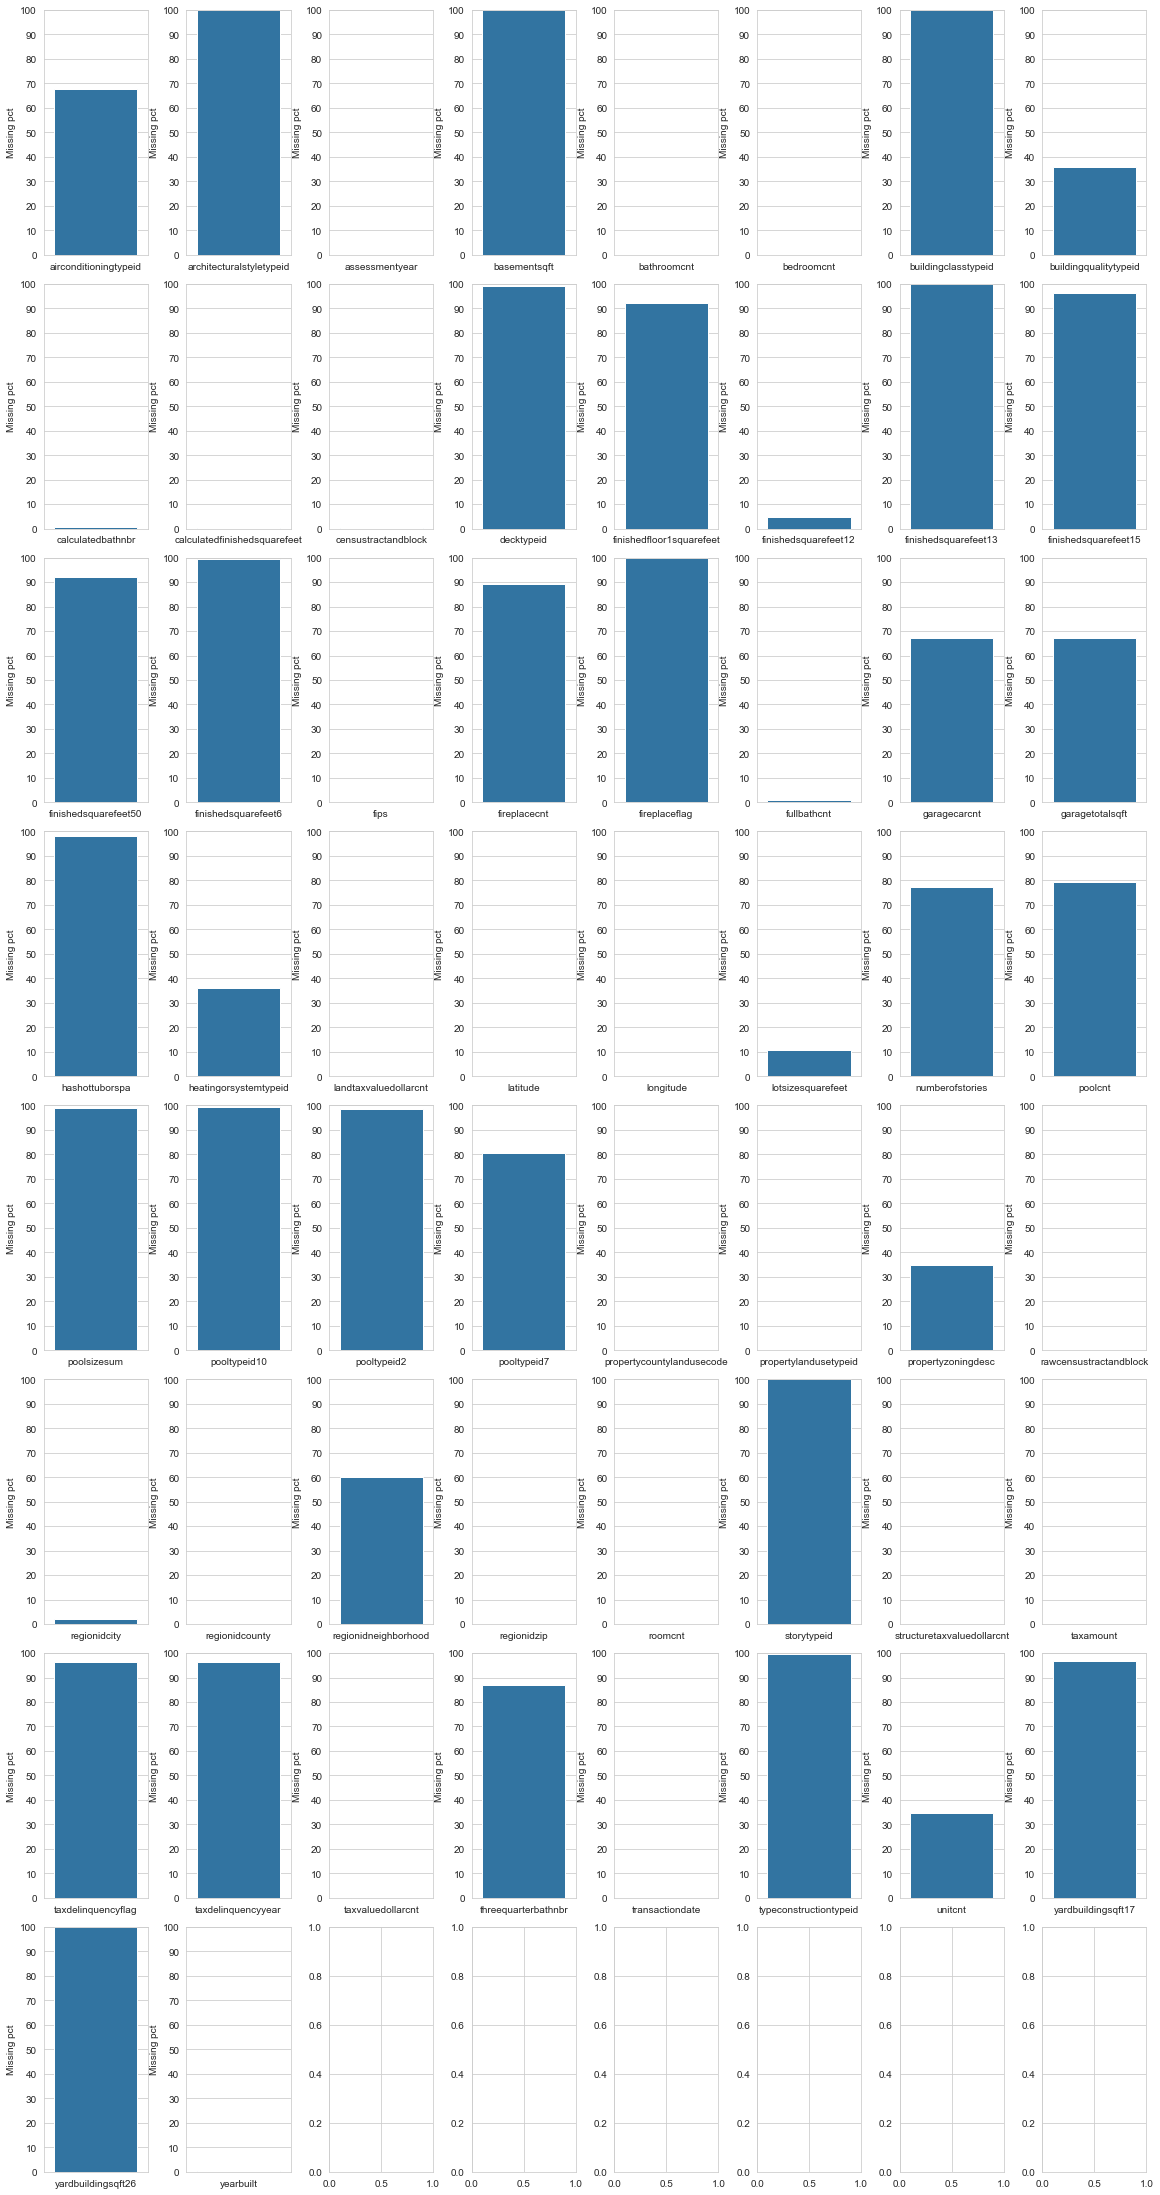

In [21]:
viz.missing_values_plot(data=missing_data, subplot_size=(2, 4), width=8)

## Unique values

In [22]:
# Check unique values of all feature
num_features = actual_data.shape[1]

for f in range(num_features):
    print (f, actual_data.iloc[:,f].unique())

0 [nan  1. 13.  5. 11.  9.]
1 [nan  7. 21.  8.  2.  3.]
2 [  nan  394.  314.  168. 1252.  396.  674.  819.  912.  204.  800. 1416.
  384.   90.  640.  380.  254.  600. 1809.  645.  786.  100.  669.  512.
  273.  300.  900.  200.  224.  515. 1969.  700.   38.  604.  405.  112.
 3112.  352. 1218.  588.  280.  252. 3560.  126.]
3 [ 5.   2.   1.5  1.   0.   2.5  3.   4.5  4.   6.   3.5  5.5  7.5  7.
 10.   8.   6.5  9.  11.   8.5 18.  13.   nan]
4 [ 4.  3.  2.  0.  5.  1.  6.  8. 11.  7.  9. 10. 12. 13. 16. 14. nan]
5 [nan  4.  3.]
6 [nan  6.  8.  7. 11.  9.  4.  3.  5. 10. 12.  1.  2.]
7 [ 5.   2.   1.5  1.   nan  2.5  3.   4.5  4.   6.   3.5  5.5  7.5  7.
 10.   8.   6.5  9.  11.   8.5 18.  13. ]
8 [nan 66.]
9 [1968. 1444. 1698. ... 1524. 1966.  569.]
10 [3760. 1444. 1698. ... 6895. 6435. 3967.]
11 [3760. 1444. 1698. ... 6895. 6435. 3967.]
12 [  nan 1440. 1152. 1536. 1488. 1344. 1056. 1300. 1392. 1512. 1248. 1200.
 1560. 1060.]
13 [  nan 1546. 1414. ... 1718. 3079. 2179.]
14 [1968. 1444.

## Numerical variables

In [23]:
num_vars = [var for var in actual_data.columns if actual_data[var].dtypes!= 'O' and len(actual_data[var].unique()) > 10] # Non-Object Variables
print("The total number of numerical variables is: ", len(num_vars))

The total number of numerical variables is:  35


In [24]:
num_vars

['basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolsizesum',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyyear',
 'censustractandblock']

In [25]:
actual_data[num_vars].head()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidneighborhood,regionidzip,roomcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,NaN,5.0,4.0,NaN,5.0,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,5.0,3.0,784.0,NaN,34449407.0,-119254052.0,42688.0,735.0,261.0,6.111001e+07,13091.0,NaN,97099.0,11.0,NaN,NaN,1982.0,501928.0,872850.0,370922.0,9673.46,NaN,6.111001e+13
1,NaN,2.0,3.0,NaN,2.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,2.0,1.0,0.0,NaN,34454169.0,-119237898.0,7108.0,NaN,261.0,6.111001e+07,13091.0,NaN,97099.0,6.0,NaN,NaN,1951.0,130845.0,436157.0,305312.0,5538.80,NaN,6.111001e+13
2,NaN,1.5,3.0,NaN,1.5,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,1.0,0.0,0.0,NaN,34365693.0,-119448392.0,2588.0,NaN,261.0,6.111001e+07,34543.0,NaN,97081.0,6.0,NaN,NaN,1979.0,193413.0,286606.0,93193.0,2987.36,NaN,6.111001e+13
3,NaN,2.0,2.0,NaN,2.0,986.0,986.0,986.0,NaN,NaN,986.0,NaN,2.0,1.0,0.0,NaN,34305600.0,-119284000.0,NaN,NaN,266.0,6.111002e+07,34543.0,NaN,97081.0,4.0,55.0,NaN,1989.0,90357.0,258888.0,168531.0,2706.24,NaN,6.111002e+13
4,NaN,1.0,2.0,NaN,1.0,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,1.0,2.0,621.0,NaN,34278012.0,-119257047.0,5643.0,NaN,261.0,6.111002e+07,34543.0,NaN,97083.0,5.0,NaN,NaN,1948.0,148752.0,592930.0,444178.0,6220.70,NaN,6.111002e+13


## Categorical variables

In [26]:
cat_vars = [var for var in actual_data.columns if var not in num_vars] # Object Variables
print("The total number of categorical variables is: ", len(cat_vars))

The total number of categorical variables is:  23


In [27]:
cat_vars

['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'decktypeid',
 'fips',
 'fireplacecnt',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'regionidcounty',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag',
 'transactiondate']

In [28]:
actual_data[cat_vars].head()

,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,decktypeid,fips,fireplacecnt,hashottuborspa,poolcnt,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,regionidcounty,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,transactiondate
0,NaN,NaN,NaN,NaN,6111.0,4.0,NaN,1.0,NaN,NaN,1.0,1110,NaN,2061.0,NaN,NaN,NaN,NaN,2.0,NaN,2016.0,NaN,2017-06-15
1,NaN,NaN,NaN,66.0,6111.0,NaN,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN,2017-07-26
2,NaN,NaN,NaN,66.0,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,1.0,NaN,NaN,1.0,NaN,2016.0,NaN,2017-07-28
3,NaN,NaN,NaN,NaN,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1129,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN,2017-06-02
4,NaN,NaN,NaN,NaN,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN,2017-07-07


In [29]:
print("Number of categories per feature:")
for var in cat_vars:
    print(var,'-->', len(actual_data[var].unique()), "Categories")

Number of categories per feature:
airconditioningtypeid --> 6 Categories
architecturalstyletypeid --> 6 Categories
buildingclasstypeid --> 3 Categories
decktypeid --> 2 Categories
fips --> 4 Categories
fireplacecnt --> 6 Categories
hashottuborspa --> 2 Categories
poolcnt --> 2 Categories
pooltypeid10 --> 2 Categories
pooltypeid2 --> 2 Categories
pooltypeid7 --> 2 Categories
propertycountylandusecode --> 76 Categories
propertyzoningdesc --> 1908 Categories
regionidcounty --> 4 Categories
storytypeid --> 2 Categories
threequarterbathnbr --> 5 Categories
typeconstructiontypeid --> 5 Categories
unitcnt --> 9 Categories
numberofstories --> 5 Categories
fireplaceflag --> 2 Categories
assessmentyear --> 2 Categories
taxdelinquencyflag --> 2 Categories
transactiondate --> 264 Categories


## Distribution of features

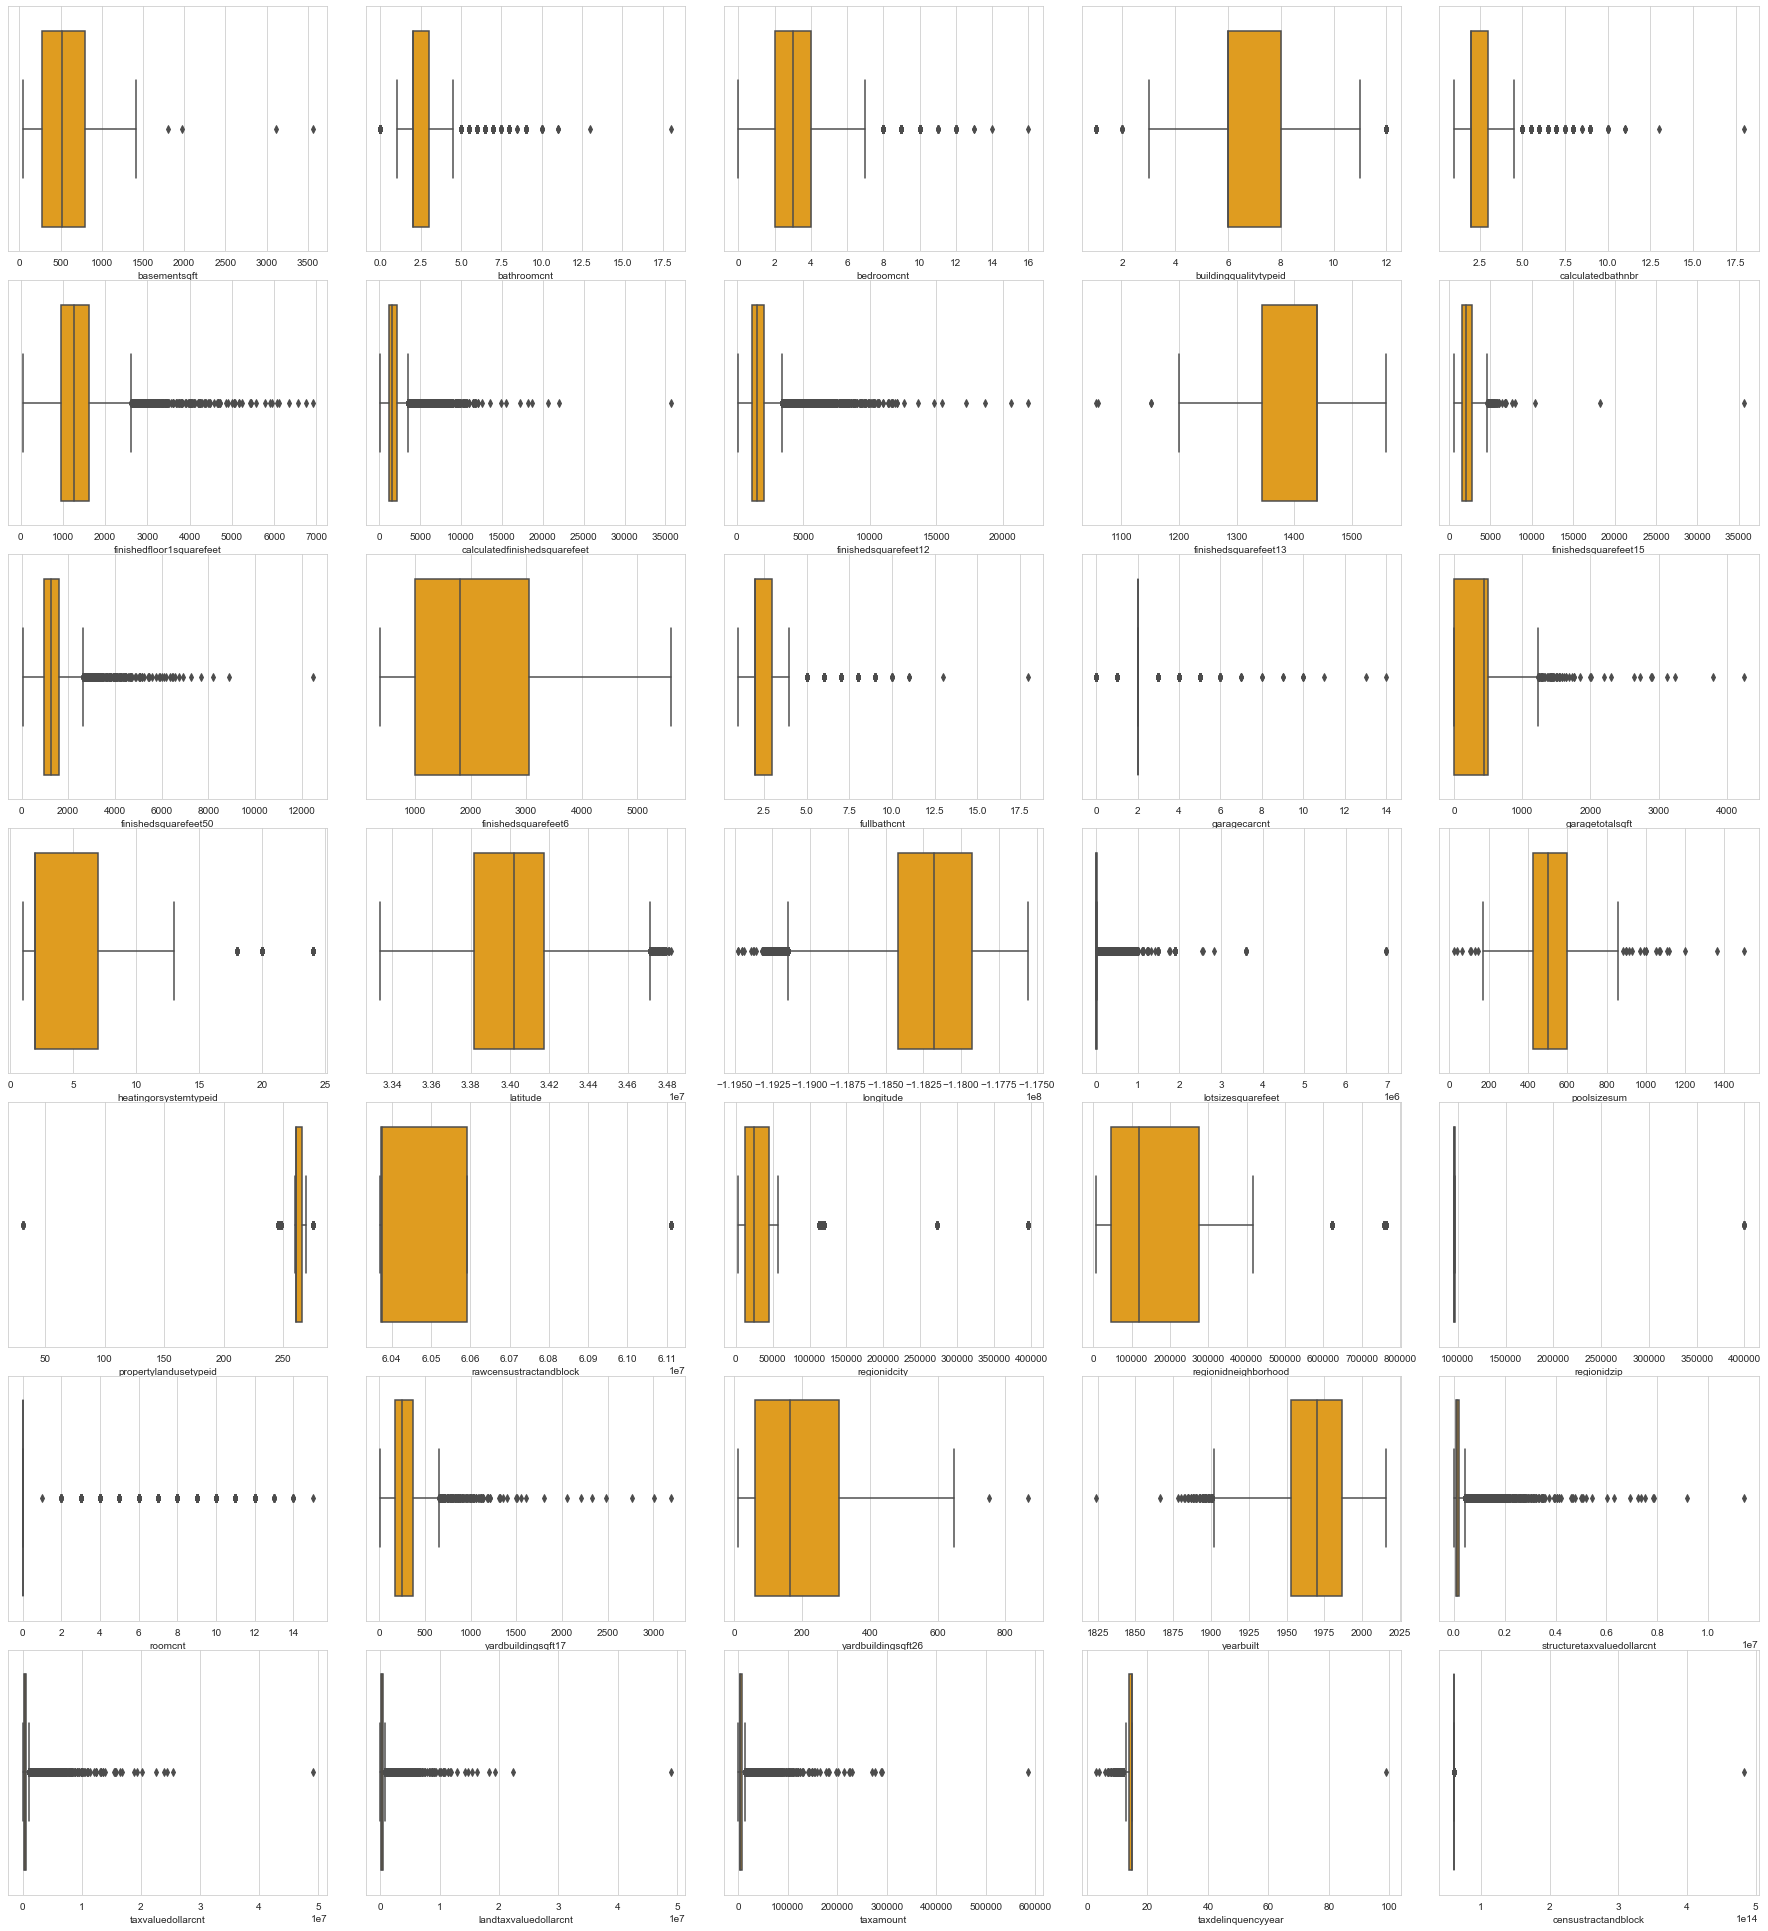

In [30]:
viz.plot_feature_distribution(actual_data,num_vars,subplot_size=(5, 4))

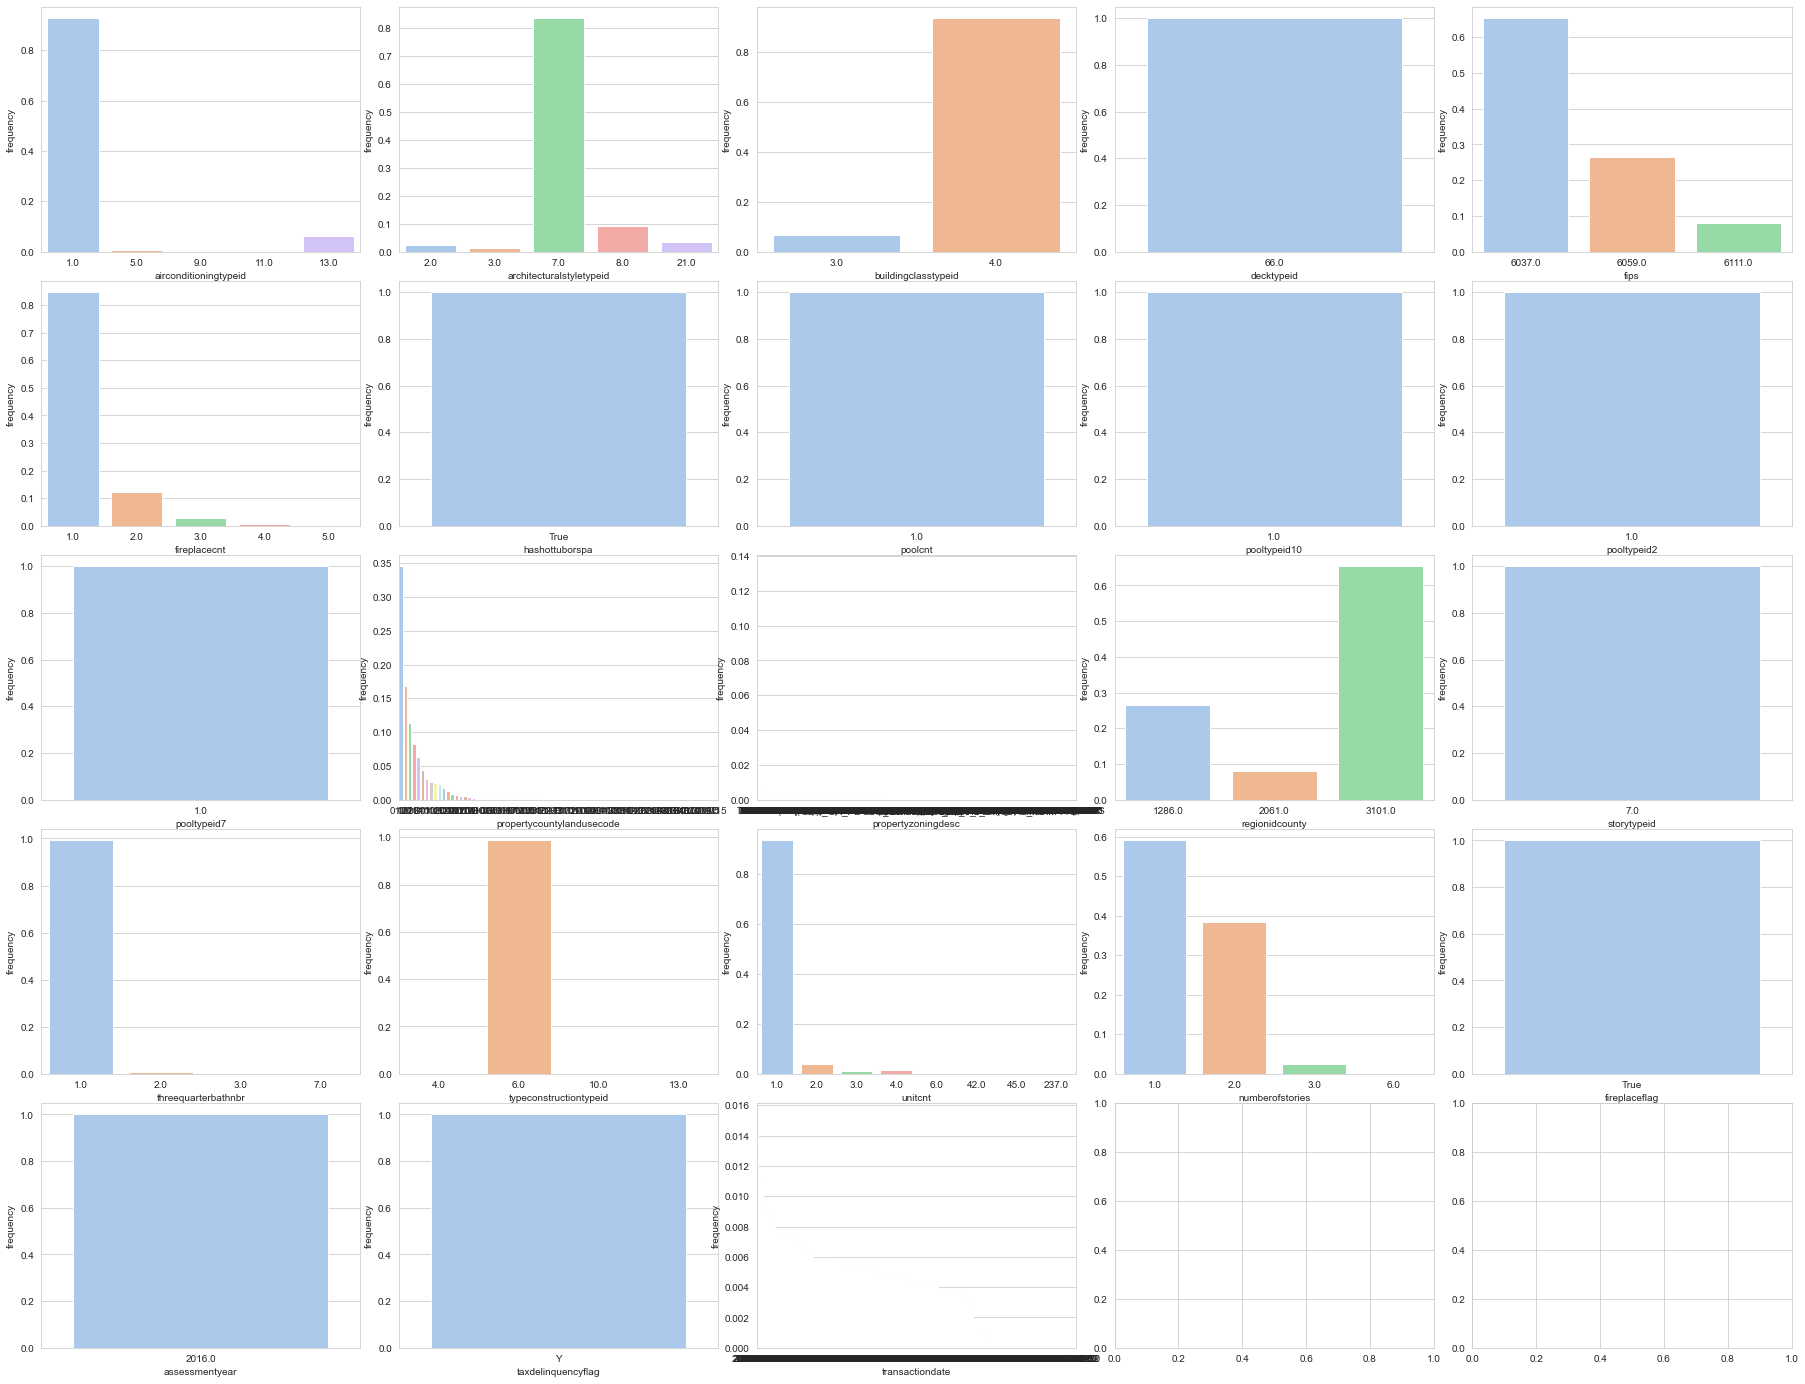

In [31]:
viz.plot_feature_distribution(actual_data,cat_vars,subplot_size=(5, 4),cat = True)

## Correlation

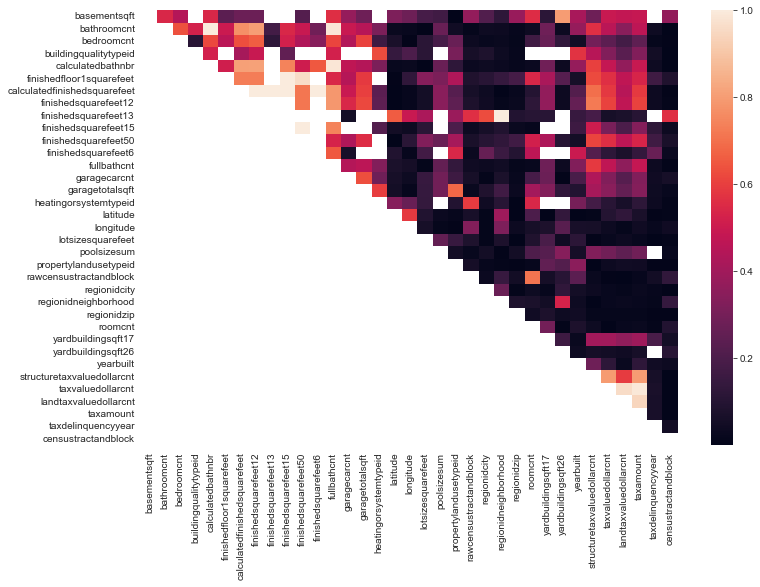

<Figure size 432x288 with 0 Axes>

In [32]:
viz.plot_correlation(actual_data,num_vars)

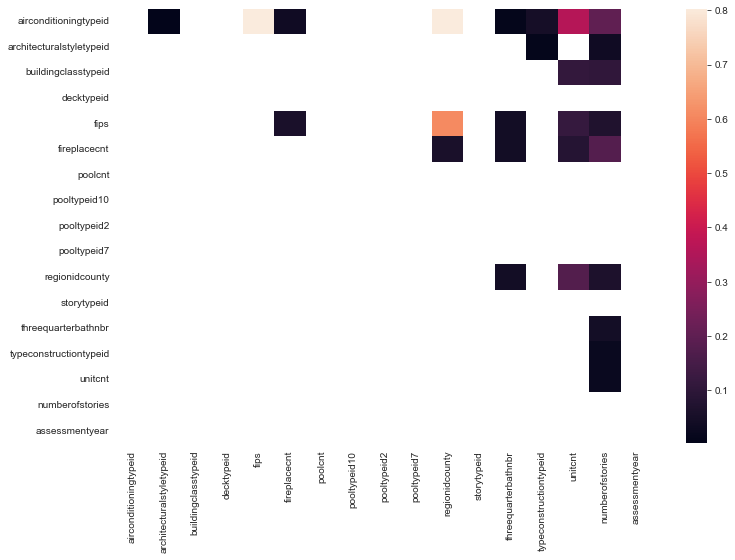

<Figure size 432x288 with 0 Axes>

In [33]:
viz.plot_correlation(actual_data,cat_vars)

# Feature Engineering

## Setup

In [34]:
# Train/Test split settings
TEST_SIZE = 0.2
Y = merged_df["logerror"]
X = actual_data

## Missing Values

In [35]:
missing_data

,Missing pct,Missing count
airconditioningtypeid,67.779882,52606.0
architecturalstyletypeid,99.733292,77406.0
assessmentyear,0.043807,34.0
basementsqft,99.935578,77563.0
bathroomcnt,0.043807,34.0
bedroomcnt,0.043807,34.0
buildingclasstypeid,99.980673,77598.0
buildingqualitytypeid,35.823895,27804.0
calculatedbathnbr,0.837489,650.0
calculatedfinishedsquarefeet,0.302784,235.0


In [36]:
print ("Number of unique values in every feature")
for c in X.columns:
    print(c, len(X[c].unique()))

Number of unique values in every feature
airconditioningtypeid 6
architecturalstyletypeid 6
basementsqft 44
bathroomcnt 23
bedroomcnt 17
buildingclasstypeid 3
buildingqualitytypeid 13
calculatedbathnbr 22
decktypeid 2
finishedfloor1squarefeet 1788
calculatedfinishedsquarefeet 4973
finishedsquarefeet12 4869
finishedsquarefeet13 14
finishedsquarefeet15 1725
finishedsquarefeet50 1808
finishedsquarefeet6 351
fips 4
fireplacecnt 6
fullbathcnt 14
garagecarcnt 15
garagetotalsqft 840
hashottuborspa 2
heatingorsystemtypeid 11
latitude 64039
longitude 62462
lotsizesquarefeet 18849
poolcnt 2
poolsizesum 263
pooltypeid10 2
pooltypeid2 2
pooltypeid7 2
propertycountylandusecode 76
propertylandusetypeid 14
propertyzoningdesc 1908
rawcensustractandblock 39189
regionidcity 176
regionidcounty 4
regionidneighborhood 481
regionidzip 390
roomcnt 17
storytypeid 2
threequarterbathnbr 5
typeconstructiontypeid 5
unitcnt 9
yardbuildingsqft17 541
yardbuildingsqft26 60
yearbuilt 137
numberofstories 5
fireplacefla

## Manual Feature Selection
Drop features with high data missing percentage and features that contain information already available.
Let's check the features' dictionary descriptions and see if they are usable. Those which seem useful will be kept.

The following variables are dropped because of their high percentage of missing data, and it would be hard to fill with artificial values.

- **architecturalstyletypeid**: Over 99% of the data is missing.
- **buildingclasstypeid**: Over 99% of the data is missing.
- **finishedfloor1squarefeet**: Over 92% of the data is missing.
- **finishedsquarefeet6**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **finishedsquarefeet13**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **finishedsquarefeet15**: Over 96% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **finishedsquarefeet50**: Over 92% of data is missing, and according to the dictionary description it represents already available information (`calculatedfinishedsquarefeet`).
- **storytypeid**: Over 99% of data is missing.
- **typeconstructiontypeid**: Over 99% of data is missing.
- **basementsqft**: Over 99% of data is missing.
- **fireplaceflag**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`fireplacecnt`).
- **pooltypeid10**: Over 99% of data is missing, and according to the dictionary description it represents already available information (`pooltypeid2`).
- **hashottuborspa**: Over 98% of data is missing, and according to the dictionary description it represents already available information (`pooltypeid2`).
- **taxdelinquencyyear**: Over 96% of data is missing, and according to the dictionary description it represents already available information (`taxdelinquencyflag`).
- **pooltypeid7**: Over 80% of data is missing, and according to the dictionary description it represents already available information (`pooltypeid2`).
- **regionidneighborhood**: Over 60% of data is missing, and information about the region can be obetained from other features.

The following features, while not having a high missing percentage of data, are dropped because they represent information already available from another variable.
- **calculatedbathnbr, fullbathcnt**: Information is already available in `bathroomcnt` which has a lower missing percentage.
- **finishedsquarefeet12**: Information is already available in `calculatedfinishedsquarefeet`.
- **propertyzoningdesc, propertycountylandusecode**: Similar information is already available in `propertylandusetypeid`.
- **regionidzip, regionidcity**: Information is already available in `regionidcounty`, `latitude` and `longitude`. These can be used to obtain information about the location.

Let's drop the aforementioned features.

In [37]:
to_drop = ["architecturalstyletypeid","buildingclasstypeid","finishedfloor1squarefeet","finishedsquarefeet6","finishedsquarefeet13","finishedsquarefeet15","finishedsquarefeet50","storytypeid","typeconstructiontypeid","basementsqft","fireplaceflag","pooltypeid10","hashottuborspa","taxdelinquencyyear","pooltypeid7","calculatedbathnbr","fullbathcnt","finishedsquarefeet12","propertyzoningdesc","propertycountylandusecode","regionidneighborhood","regionidzip","regionidcity"]
X_1 = X.drop(to_drop, axis=1)
X_1

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,transactiondate
0,NaN,5.0,4.0,NaN,NaN,3760.0,6111.0,4.0,3.0,784.0,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,261.0,6.111001e+07,2061.0,11.0,NaN,NaN,NaN,NaN,1982.0,2.0,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,6.111001e+13,2017-06-15
1,NaN,2.0,3.0,NaN,66.0,1444.0,6111.0,NaN,1.0,0.0,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,261.0,6.111001e+07,2061.0,6.0,NaN,NaN,NaN,NaN,1951.0,1.0,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,6.111001e+13,2017-07-26
2,NaN,1.5,3.0,NaN,66.0,1698.0,6111.0,1.0,0.0,0.0,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,261.0,6.111001e+07,2061.0,6.0,1.0,NaN,NaN,NaN,1979.0,1.0,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,6.111001e+13,2017-07-28
3,NaN,2.0,2.0,NaN,NaN,986.0,6111.0,1.0,1.0,0.0,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,266.0,6.111002e+07,2061.0,4.0,NaN,NaN,55.0,NaN,1989.0,1.0,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,6.111002e+13,2017-06-02
4,NaN,1.0,2.0,NaN,NaN,1170.0,6111.0,1.0,2.0,621.0,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,261.0,6.111002e+07,2061.0,5.0,NaN,NaN,NaN,NaN,1948.0,1.0,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,6.111002e+13,2017-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-12
77609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-03
77610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-23
77611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-23


### Save the new dataset

In [38]:
if not os.path.exists("../data/lvl1_fe"):
    os.mkdir("../data/lvl1_fe")
X_1.to_csv('../data/lvl1_fe/notfilled_properties_2017.csv', index=False)

#### Train/Test Split

In [43]:
X1_train_80, X1_test, Y_train_80, Y_test = train_test_split( X_1, Y,test_size=0.20,random_state=RNDSTATE)
X1_split = fe.TrainTestSplit(X1_train_80, X1_test, Y_train_80, Y_test)
X1_split.x_train.info(verbose=True, show_counts=True)
X1_split.x_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 2140 to 42241
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         19948 non-null  float64
 1   bathroomcnt                   62062 non-null  float64
 2   bedroomcnt                    62062 non-null  float64
 3   buildingqualitytypeid         39844 non-null  float64
 4   decktypeid                    490 non-null    float64
 5   calculatedfinishedsquarefeet  61899 non-null  float64
 6   fips                          62062 non-null  float64
 7   fireplacecnt                  6636 non-null   float64
 8   garagecarcnt                  20407 non-null  float64
 9   garagetotalsqft               20407 non-null  float64
 10  heatingorsystemtypeid         39691 non-null  float64
 11  latitude                      62062 non-null  float64
 12  longitude                     62062 non-null  float64
 13

## Replacing missing values
The missing values will be replaced following these criteria:
- replace with mean/median/mode using values already present in the feature if missing percentage of data is low
- replace with 0 if the feature asks for a specified category, a simple flag, or a number

In [45]:
NO_QTY = 0
NO_FLAG = "N"

fill_with_0 = {
    "decktypeid": NO_QTY, # missing value likely means no deck is present, the only available value is 66, so we can use 0
    "threequarterbathnbr": NO_QTY, # missing value likely means no 3/4 bath is present
    "fireplacecnt": NO_QTY, #missing value likely means no fireplace is present
    "garagecarcnt": NO_QTY, #missing value likely means no garage is present since there is no property with 0 value
    "garagetotalsqft": NO_QTY, #missing value likely means no garage, so 0 square feet
    "poolcnt": NO_QTY, #missing value likely means no pool is present
    "poolsizesum": NO_QTY, #missing value likely means no pool so 0 square footage
    "pooltypeid2": NO_QTY, #missing value likely means no pool with spa/hot tub is present
    "yardbuildingsqft17": NO_QTY, #missing value likely means no patio in yard
    "yardbuildingsqft26": NO_QTY, #missing value likely means no building in yard
    "taxdelinquencyflag": NO_FLAG # missing value likely means that the properties are not tax delinquent (the only value is Y)
}

fillna_train = {
    "airconditioningtypeid": X1_split.x_train["airconditioningtypeid"].mode(dropna=True)[0], # the majority of properties have type 1 which is central
    "bathroomcnt": X1_split.x_train["bathroomcnt"].median(skipna=True),
    "bedroomcnt": X1_split.x_train["bedroomcnt"].median(skipna=True),
    "buildingqualitytypeid": X1_split.x_train["buildingqualitytypeid"].median(skipna=True), # using median for missing values since the  condition of the building goes from best (lowest) to worst (highest)
    "calculatedfinishedsquarefeet": X1_split.x_train["calculatedfinishedsquarefeet"].median(skipna=True),
    "fips": X1_split.x_train["fips"].mode(dropna=True)[0],
    "heatingorsystemtypeid": X1_split.x_train["heatingorsystemtypeid"].mode(dropna=True)[0], # the majority of properties have type 2 which is central
    "latitude": X1_split.x_train["latitude"].median(skipna=True),
    "longitude": X1_split.x_train["longitude"].median(skipna=True),
    "lotsizesquarefeet": X1_split.x_train["lotsizesquarefeet"].median(skipna=True),
    "numberofstories": X1_split.x_train["numberofstories"].median(skipna=True),
    "propertylandusetypeid": X1_split.x_train["propertylandusetypeid"].mode(dropna=True)[0], # only 4% of missing data, seems reasonable to use the mode which is "Single Family Residential" (id = 261)
    "rawcensustractandblock": X1_split.x_train["rawcensustractandblock"].mode(dropna=True)[0],
    "censustractandblock": X1_split.x_train["censustractandblock"].mode(dropna=True)[0],
    "regionidcounty": X1_split.x_train["regionidcounty"].mode(dropna=True)[0],
    "roomcnt": X1_split.x_train["roomcnt"].mode(dropna=True)[0],
    "unitcnt": X1_split.x_train["unitcnt"].mode(dropna=True)[0], # the majority of properties are built into 1 unit
    "yearbuilt": X1_split.x_train["yearbuilt"].mode(dropna=True)[0],
    "taxvaluedollarcnt": X1_split.x_train["taxvaluedollarcnt"].median(skipna=True),
    "structuretaxvaluedollarcnt": X1_split.x_train["structuretaxvaluedollarcnt"].median(skipna=True),
    "landtaxvaluedollarcnt": X1_split.x_train["landtaxvaluedollarcnt"].median(skipna=True),
    "taxamount": X1_split.x_train["taxamount"].median(skipna=True),
    "assessmentyear": X1_split.x_train["assessmentyear"].mode(dropna=True)[0],
}

fillna_test = {
    "airconditioningtypeid": X1_split.x_test["airconditioningtypeid"].mode(dropna=True)[0], # the majority of properties have type 1 which is central
    "bathroomcnt": X1_split.x_test["bathroomcnt"].median(skipna=True),
    "bedroomcnt": X1_split.x_test["bedroomcnt"].median(skipna=True),
    "buildingqualitytypeid": X1_split.x_test["buildingqualitytypeid"].median(skipna=True), # using median for missing values since the  condition of the building goes from best (lowest) to worst (highest)
    "calculatedfinishedsquarefeet": X1_split.x_test["calculatedfinishedsquarefeet"].median(skipna=True),
    "fips": X1_split.x_test["fips"].mode(dropna=True)[0],
    "heatingorsystemtypeid": X1_split.x_test["heatingorsystemtypeid"].mode(dropna=True)[0], # the majority of properties have type 2 which is central
    "latitude": X1_split.x_test["latitude"].median(skipna=True),
    "longitude": X1_split.x_test["longitude"].median(skipna=True),
    "lotsizesquarefeet": X1_split.x_test["lotsizesquarefeet"].median(skipna=True),
    "numberofstories": X1_split.x_test["numberofstories"].median(skipna=True),
    "propertylandusetypeid": X1_split.x_test["propertylandusetypeid"].mode(dropna=True)[0], # only 4% of missing data, seems reasonable to use the mode which is "Single Family Residential" (id = 261)
    "rawcensustractandblock": X1_split.x_test["rawcensustractandblock"].mode(dropna=True)[0],
    "censustractandblock": X1_split.x_test["censustractandblock"].mode(dropna=True)[0],
    "regionidcounty": X1_split.x_test["regionidcounty"].mode(dropna=True)[0],
    "roomcnt": X1_split.x_test["roomcnt"].mode(dropna=True)[0],
    "unitcnt": X1_split.x_test["unitcnt"].mode(dropna=True)[0], # the majority of properties are built into 1 unit
    "yearbuilt": X1_split.x_test["yearbuilt"].mode(dropna=True)[0],
    "taxvaluedollarcnt": X1_split.x_test["taxvaluedollarcnt"].median(skipna=True),
    "structuretaxvaluedollarcnt": X1_split.x_test["structuretaxvaluedollarcnt"].median(skipna=True),
    "landtaxvaluedollarcnt": X1_split.x_test["landtaxvaluedollarcnt"].median(skipna=True),
    "taxamount": X1_split.x_test["taxamount"].median(skipna=True),
    "assessmentyear": X1_split.x_test["assessmentyear"].mode(dropna=True)[0],
}

x_train_fill = X1_split.x_train.fillna(fill_with_0)
x_train_fill = x_train_fill.fillna(fillna_train)

x_test_fill = X1_split.x_test.fillna(fill_with_0)
x_test_fill = x_test_fill.fillna(fillna_test)

X2_split_fill = fe.TrainTestSplit(x_train_fill, x_test_fill, X1_split.y_train, X1_split.y_test)

In [49]:
X2_split_fill.x_train.info(verbose=True)
X2_split_fill.x_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 2140 to 42241
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         62090 non-null  float64
 1   bathroomcnt                   62090 non-null  float64
 2   bedroomcnt                    62090 non-null  float64
 3   buildingqualitytypeid         62090 non-null  float64
 4   decktypeid                    62090 non-null  float64
 5   calculatedfinishedsquarefeet  62090 non-null  float64
 6   fips                          62090 non-null  float64
 7   fireplacecnt                  62090 non-null  float64
 8   garagecarcnt                  62090 non-null  float64
 9   garagetotalsqft               62090 non-null  float64
 10  heatingorsystemtypeid         62090 non-null  float64
 11  latitude                      62090 non-null  float64
 12  longitude                     62090 non-null  float64
 13

In [53]:
X_2 = pd.concat([X2_split_fill.x_train, X2_split_fill.x_test])
X_2.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 2140 to 17496
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77613 non-null  float64
 1   bathroomcnt                   77613 non-null  float64
 2   bedroomcnt                    77613 non-null  float64
 3   buildingqualitytypeid         77613 non-null  float64
 4   decktypeid                    77613 non-null  float64
 5   calculatedfinishedsquarefeet  77613 non-null  float64
 6   fips                          77613 non-null  float64
 7   fireplacecnt                  77613 non-null  float64
 8   garagecarcnt                  77613 non-null  float64
 9   garagetotalsqft               77613 non-null  float64
 10  heatingorsystemtypeid         77613 non-null  float64
 11  latitude                      77613 non-null  float64
 12  longitude                     77613 non-null  float64
 13

There are no more missing values.

In [54]:
X_2.nunique()

airconditioningtypeid               5
bathroomcnt                        22
bedroomcnt                         16
buildingqualitytypeid              12
decktypeid                          2
calculatedfinishedsquarefeet     4972
fips                                3
fireplacecnt                        6
garagecarcnt                       14
garagetotalsqft                   839
heatingorsystemtypeid              10
latitude                        64039
longitude                       62462
lotsizesquarefeet               18848
poolcnt                             2
poolsizesum                       263
pooltypeid2                         2
propertylandusetypeid              13
rawcensustractandblock          39188
regionidcounty                      3
roomcnt                            16
threequarterbathnbr                 5
unitcnt                             8
yardbuildingsqft17                541
yardbuildingsqft26                 60
yearbuilt                         136
numberofstor

In [55]:
X_2.T[X_2.nunique().values == 1]

,2140,7202,75783,59523,35976,32387,9252,65399,52024,62226,47629,10333,57522,2307,16607,62006,26543,19711,13069,73228,36568,69314,42878,56458,67425,54088,77054,38592,49340,71905,14830,47294,36401,40907,30115,5022,40906,25465,58468,64048,3751,135,15318,28726,9808,42087,56042,18081,10380,32992,...,36065,32648,20899,48549,21437,15180,10842,56754,72485,77408,40339,69840,33135,45719,16999,29665,32744,61086,17097,3560,55225,5400,53662,68180,60882,59779,1532,3672,10794,44336,16913,69143,56570,33579,36998,8052,37292,61582,72621,43484,56285,60026,12049,62938,15517,189,45878,27006,44118,17496
assessmentyear,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0


We can drop the feature 'assessmentyear' since it has only 1 unique value.

In [63]:
X2_split_fill_1 = X2_split_fill.drop_features(features_to_drop=["assessmentyear"])
X2_split_fill_1.x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 2140 to 42241
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         62090 non-null  float64
 1   bathroomcnt                   62090 non-null  float64
 2   bedroomcnt                    62090 non-null  float64
 3   buildingqualitytypeid         62090 non-null  float64
 4   decktypeid                    62090 non-null  float64
 5   calculatedfinishedsquarefeet  62090 non-null  float64
 6   fips                          62090 non-null  float64
 7   fireplacecnt                  62090 non-null  float64
 8   garagecarcnt                  62090 non-null  float64
 9   garagetotalsqft               62090 non-null  float64
 10  heatingorsystemtypeid         62090 non-null  float64
 11  latitude                      62090 non-null  float64
 12  longitude                     62090 non-null  float64
 13

## Adding New Simple Features
Adding new features by extracting information from already present features:
- Adding **house_age** feature as the years difference between **transactiondate** and **yearbuilt**. The old features will be dropped.

In [65]:
trans_date_train = pd.to_datetime(X2_split_fill_1.x_train["transactiondate"]).dt.year
trans_date_test = pd.to_datetime(X2_split_fill_1.x_test["transactiondate"]).dt.year

X2_split_fill_1.x_train["house_age"] = trans_date_train - X2_split_fill_1.x_train["yearbuilt"]
X2_split_fill_1.x_test["house_age"] = trans_date_test - X2_split_fill_1.x_test["yearbuilt"]

X2_split_fill_2 = X2_split_fill_1.drop_features(features_to_drop=["yearbuilt","transactiondate"])
X2_split_fill_2.x_train.info(verbose=True)
X2_split_fill_2.x_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 2140 to 42241
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         62090 non-null  float64
 1   bathroomcnt                   62090 non-null  float64
 2   bedroomcnt                    62090 non-null  float64
 3   buildingqualitytypeid         62090 non-null  float64
 4   decktypeid                    62090 non-null  float64
 5   calculatedfinishedsquarefeet  62090 non-null  float64
 6   fips                          62090 non-null  float64
 7   fireplacecnt                  62090 non-null  float64
 8   garagecarcnt                  62090 non-null  float64
 9   garagetotalsqft               62090 non-null  float64
 10  heatingorsystemtypeid         62090 non-null  float64
 11  latitude                      62090 non-null  float64
 12  longitude                     62090 non-null  float64
 13

### Transform incorrectly scaled variables
As we can see in the data dictionary, the variables latitude and longitude have been multiplied. So we will scale them to their original value.

In [78]:
X2_split_fill_2.x_train[['latitude', 'longitude']] = (X2_split_fill_2.x_train[['latitude', 'longitude']])/(10**6)
X2_split_fill_2.x_test[['latitude', 'longitude']] = (X2_split_fill_2.x_test[['latitude', 'longitude']])/(10**6)

In [81]:
X_2 = pd.concat([X2_split_fill_2.x_train, X2_split_fill_2.x_test])
X_2.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 2140 to 17496
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77613 non-null  float64
 1   bathroomcnt                   77613 non-null  float64
 2   bedroomcnt                    77613 non-null  float64
 3   buildingqualitytypeid         77613 non-null  float64
 4   decktypeid                    77613 non-null  float64
 5   calculatedfinishedsquarefeet  77613 non-null  float64
 6   fips                          77613 non-null  float64
 7   fireplacecnt                  77613 non-null  float64
 8   garagecarcnt                  77613 non-null  float64
 9   garagetotalsqft               77613 non-null  float64
 10  heatingorsystemtypeid         77613 non-null  float64
 11  latitude                      77613 non-null  float64
 12  longitude                     77613 non-null  float64
 13

### Search for correlated features

In [82]:
num_vars = [var for var in X_2.columns if len(X_2[var].unique()) > 10]
cat_vars = [var for var in X_2.columns if var not in num_vars]

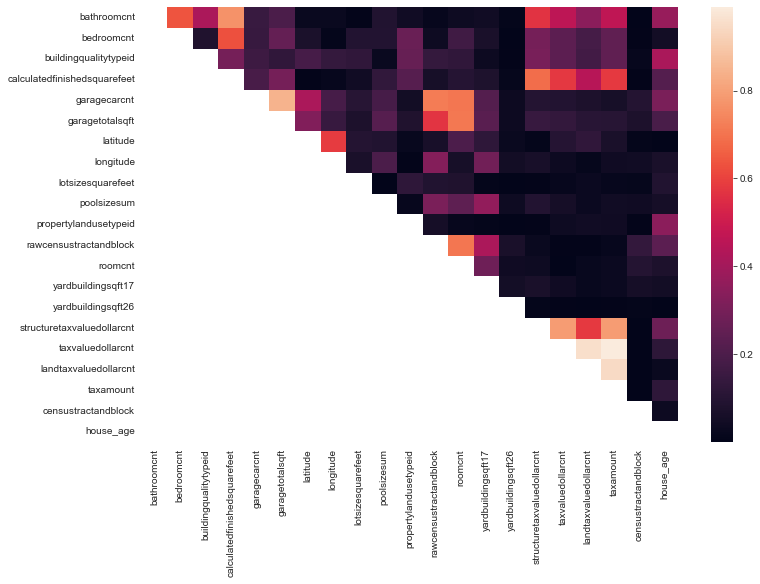

<Figure size 432x288 with 0 Axes>

In [83]:
viz.plot_correlation(X_2,num_vars)

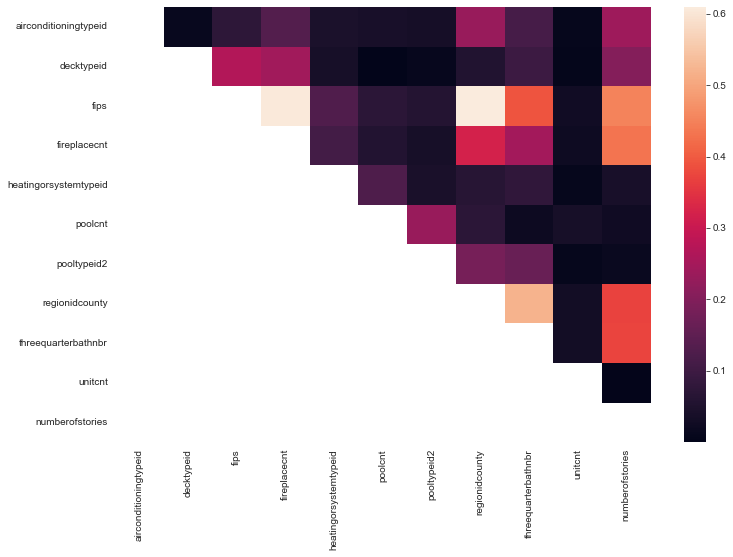

<Figure size 432x288 with 0 Axes>

In [84]:
viz.plot_correlation(X_2,cat_vars)

From the looks of it, the following features are highly correlated:
- **structuretaxvaluedollarcnt**, **taxvaluedollarcnt**, **landtaxvaluedollarcnt**
- **fips**, **fireplacecnt**, **regionidcounty**

By checking the dictionary descriptions of these features, we can see that some contain the same information.
- **fips** and **regionidcounty** have similar information, so we will get rid of **fips**.
- **fireplacecnt** seems to be just a coincidence, so we will leave it for the moment.
- **taxvaluedollarcnt** is derived from the sum of **structuretaxvaluedollarcnt** and **landtaxvaluedollarcnt**, so it can be dropped.

After further studies, **rawcensustractandblock** and **censustractandblock**, which we left out previously, aside from being the same information according to the data dictionary, contain location related information, and we already have that, so they will be dropped.

In [87]:
to_drop = ["fips","taxvaluedollarcnt","rawcensustractandblock","censustractandblock"]

X2_split_fill_3 = X2_split_fill_2.drop_features(features_to_drop=to_drop)
X2_split_fill_3.x_train.info(verbose=True)
X2_split_fill_3.x_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 2140 to 42241
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         62090 non-null  float64
 1   bathroomcnt                   62090 non-null  float64
 2   bedroomcnt                    62090 non-null  float64
 3   buildingqualitytypeid         62090 non-null  float64
 4   decktypeid                    62090 non-null  float64
 5   calculatedfinishedsquarefeet  62090 non-null  float64
 6   fireplacecnt                  62090 non-null  float64
 7   garagecarcnt                  62090 non-null  float64
 8   garagetotalsqft               62090 non-null  float64
 9   heatingorsystemtypeid         62090 non-null  float64
 10  latitude                      62090 non-null  float64
 11  longitude                     62090 non-null  float64
 12  lotsizesquarefeet             62090 non-null  float64
 13

### Save the filled dataset

In [86]:
X2_split_fill_3.to_csv(dir_path='../data/lvl1_fe')

# Encoding Categorical Data

What feature contains categorical data?
After reading the data dictionary carefully, we can say that the features containing the following words in their name are categorical data: "id"; "flag"; "has"; "code"; or "desc"; let's find them and encode them with One Hot Encoding.

In [88]:
X_2 = pd.concat([X2_split_fill_3.x_train, X2_split_fill_3.x_test])
X_2.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 2140 to 17496
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77613 non-null  float64
 1   bathroomcnt                   77613 non-null  float64
 2   bedroomcnt                    77613 non-null  float64
 3   buildingqualitytypeid         77613 non-null  float64
 4   decktypeid                    77613 non-null  float64
 5   calculatedfinishedsquarefeet  77613 non-null  float64
 6   fireplacecnt                  77613 non-null  float64
 7   garagecarcnt                  77613 non-null  float64
 8   garagetotalsqft               77613 non-null  float64
 9   heatingorsystemtypeid         77613 non-null  float64
 10  latitude                      77613 non-null  float64
 11  longitude                     77613 non-null  float64
 12  lotsizesquarefeet             77613 non-null  float64
 13

In [89]:
# Identifier contained in categorical features' name
is_cat = ["id", "flag", "has", "code", "desc"]
cat_vars = fe.get_features_from_name(df=X_2,
                                         identifiers=is_cat)
cat_vars_name = cat_vars.columns
num_vars_name = [var for var in X_2.columns if var not in cat_vars_name]
cat_vars_name

Index(['airconditioningtypeid', 'buildingqualitytypeid', 'decktypeid',
       'heatingorsystemtypeid', 'pooltypeid2', 'propertylandusetypeid',
       'regionidcounty', 'taxdelinquencyflag'],
      dtype='object')

In [92]:
X2_split_fill_3.x_train[cat_vars_name].nunique()

airconditioningtypeid     5
buildingqualitytypeid    12
decktypeid                2
heatingorsystemtypeid    10
pooltypeid2               2
propertylandusetypeid    13
regionidcounty            3
taxdelinquencyflag        2
dtype: int64

In [ ]:
X2_split_fill_3.x_test[cat_vars_name].nunique()

## Visualization
Before One-Hot Encoding

### Distribution of features

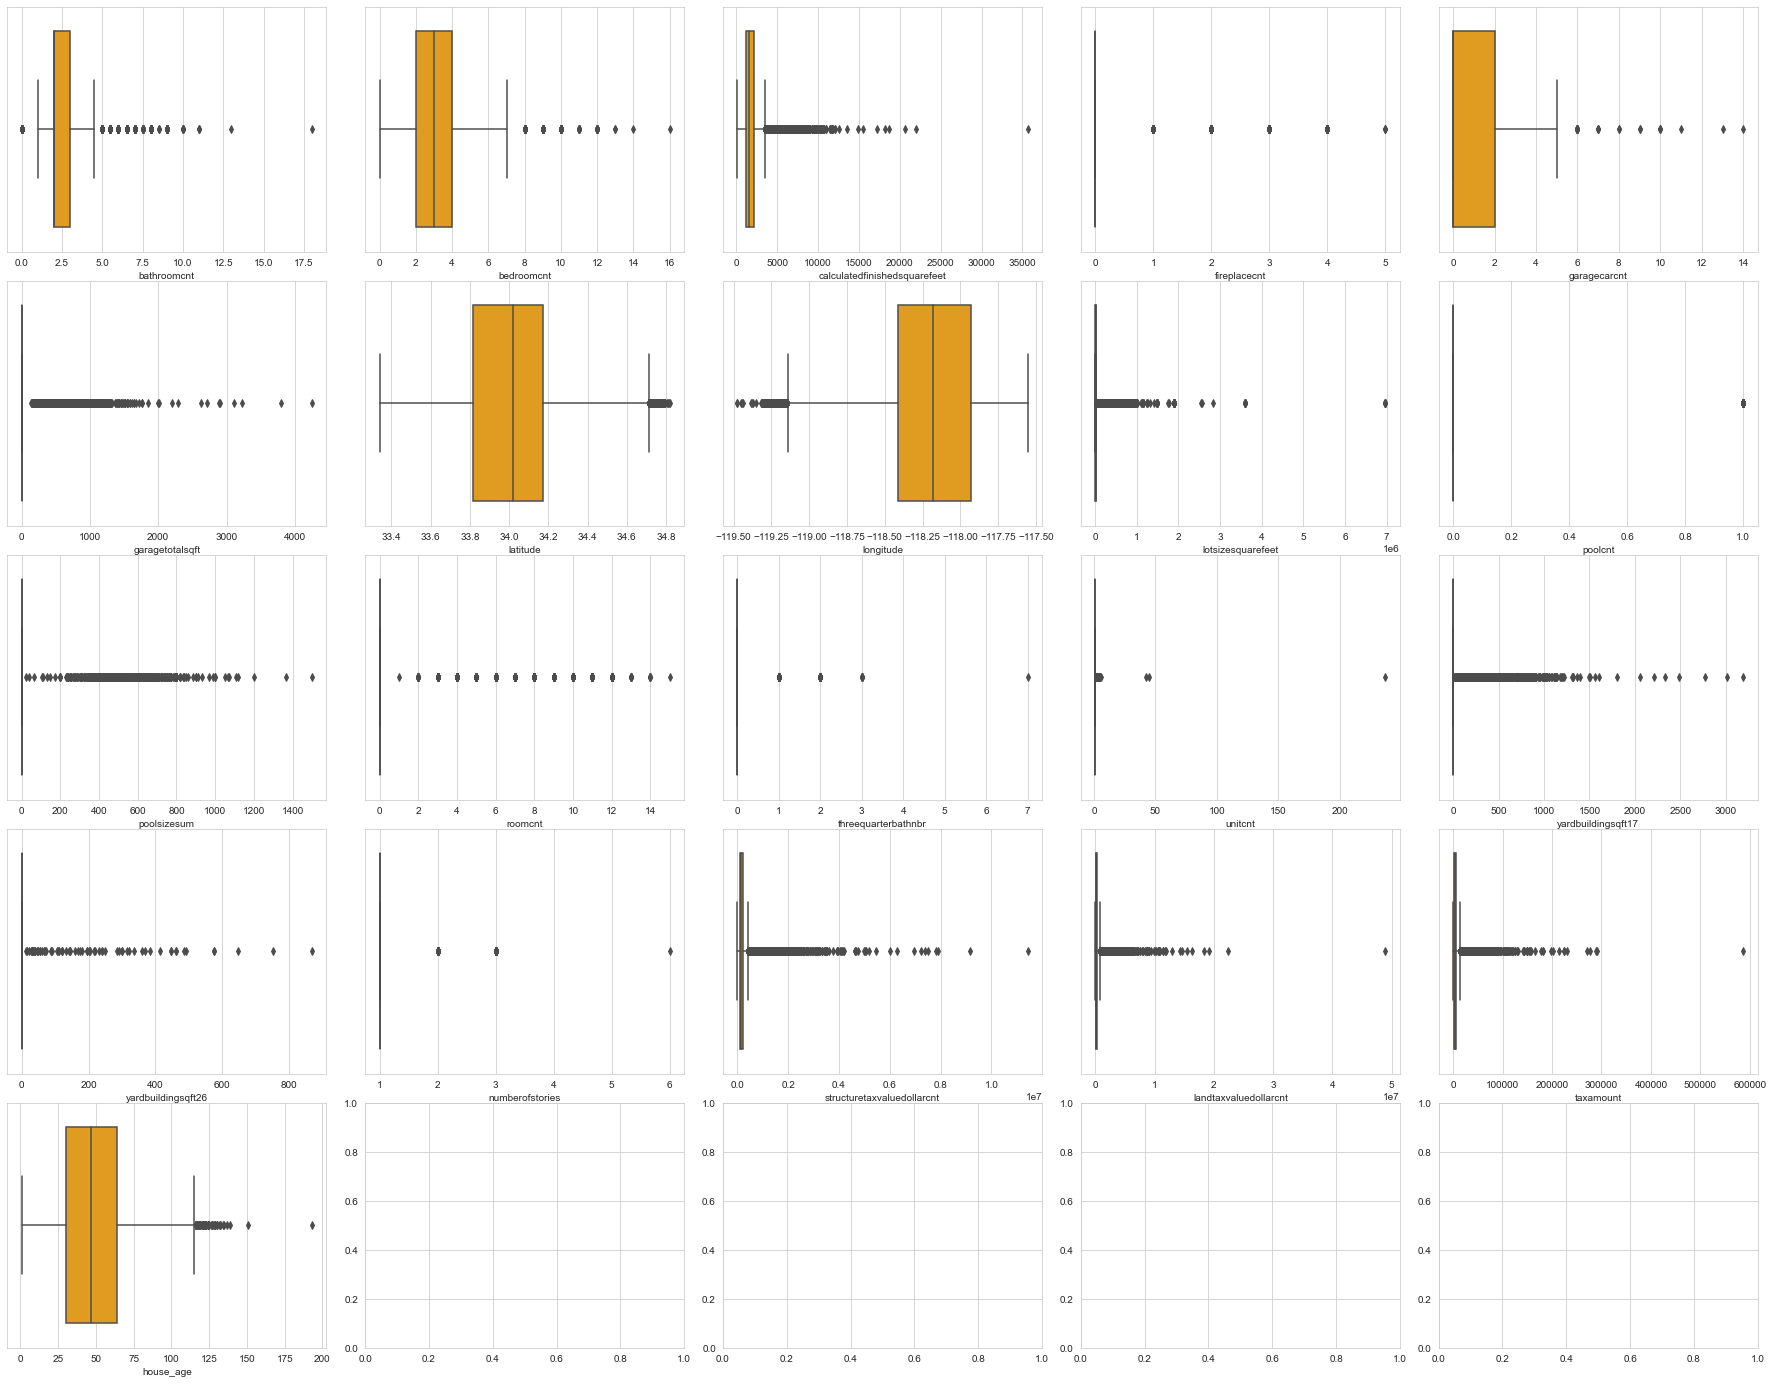

In [94]:
viz.plot_feature_distribution(X_2,num_vars_name,subplot_size=(5, 4))

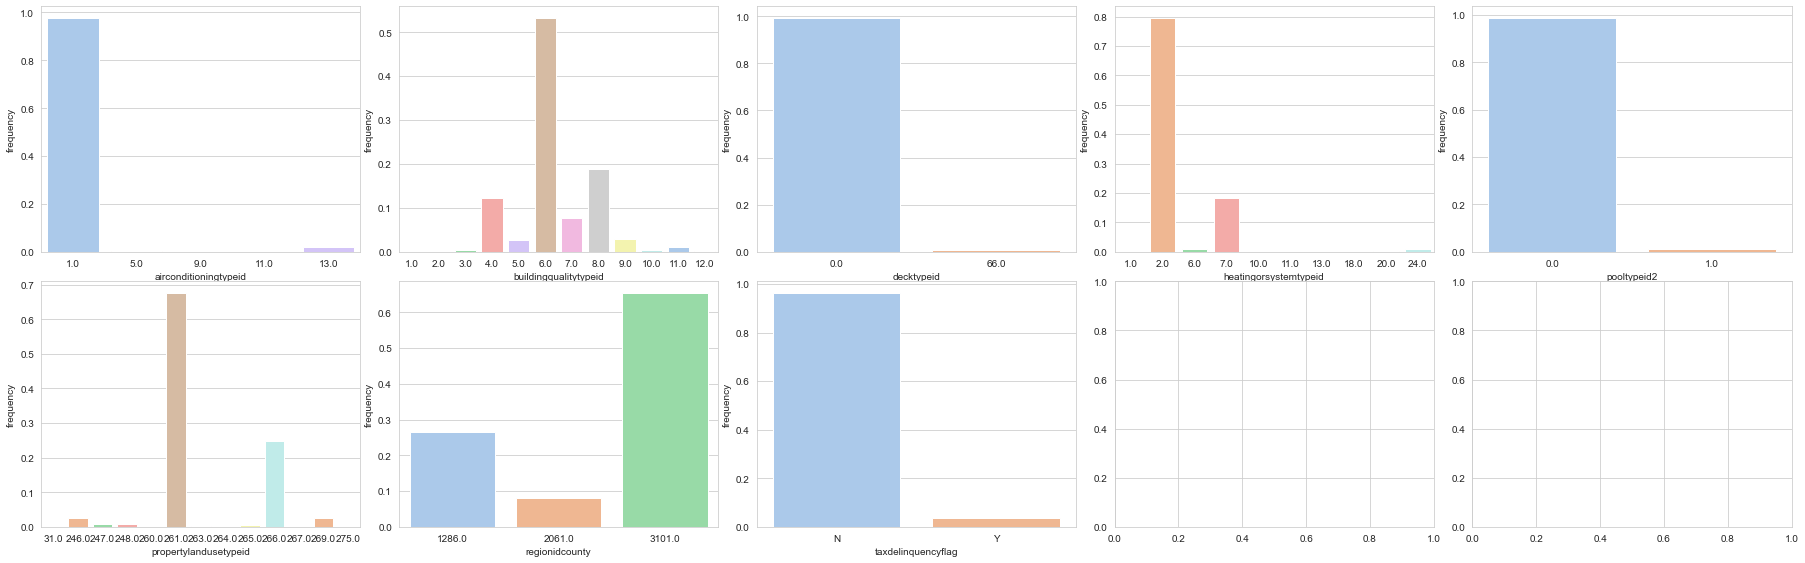

In [95]:
viz.plot_feature_distribution(X_2,cat_vars_name,subplot_size=(5, 4),cat = True)

### Correlation

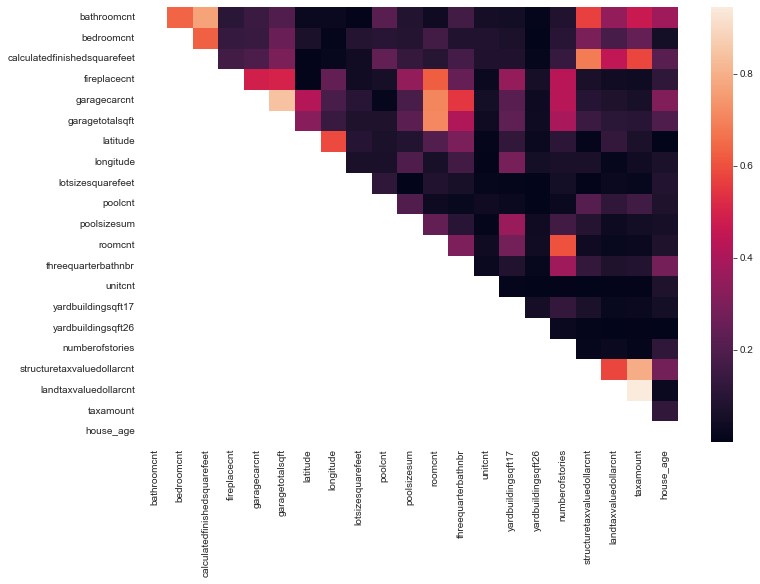

<Figure size 432x288 with 0 Axes>

In [96]:
viz.plot_correlation(X_2,num_vars_name)

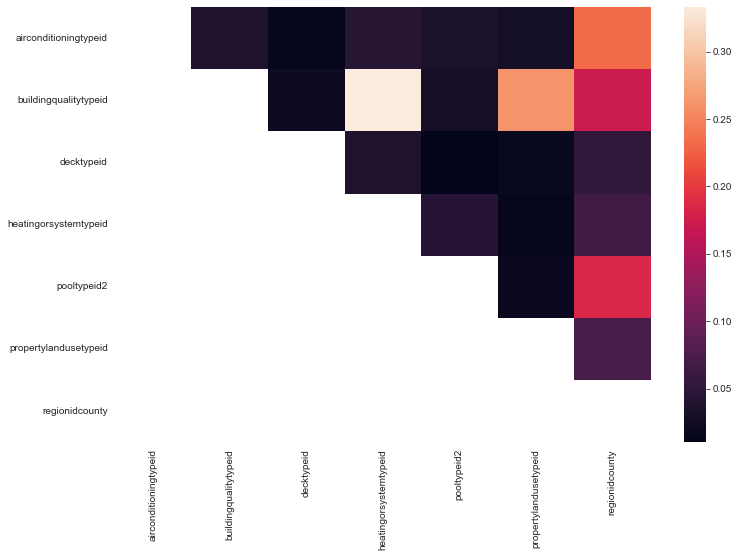

<Figure size 432x288 with 0 Axes>

In [97]:
viz.plot_correlation(X_2,cat_vars_name)

## One-Hot Encoding

In [98]:
ohe_enc = fe.ohe_fit(cat_vars)
x_train_ohe = fe.ohe_transform(df=X2_split_fill_3.x_train, cat_features=cat_vars_name, ohe=ohe_enc)
x_test_ohe= fe.ohe_transform(df=X2_split_fill_3.x_test, cat_features=cat_vars_name, ohe=ohe_enc)
X2_split_ohe = fe.TrainTestSplit(x_train_ohe, x_test_ohe, X2_split_fill_3.y_train, X2_split_fill_3.y_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [99]:
X2_split_ohe.x_train.info(verbose=True)
X2_split_ohe.x_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62090 entries, 2140 to 42241
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   62090 non-null  float64
 1   bedroomcnt                    62090 non-null  float64
 2   calculatedfinishedsquarefeet  62090 non-null  float64
 3   fireplacecnt                  62090 non-null  float64
 4   garagecarcnt                  62090 non-null  float64
 5   garagetotalsqft               62090 non-null  float64
 6   latitude                      62090 non-null  float64
 7   longitude                     62090 non-null  float64
 8   lotsizesquarefeet             62090 non-null  float64
 9   poolcnt                       62090 non-null  float64
 10  poolsizesum                   62090 non-null  float64
 11  roomcnt                       62090 non-null  float64
 12  threequarterbathnbr           62090 non-null  float64
 13

## Visualization
After One-Hot Encoding

In [100]:
X2_ohe = pd.concat([X2_split_ohe.x_train, X2_split_ohe.x_test])
X2_ohe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 2140 to 17496
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77613 non-null  float64
 1   bedroomcnt                    77613 non-null  float64
 2   calculatedfinishedsquarefeet  77613 non-null  float64
 3   fireplacecnt                  77613 non-null  float64
 4   garagecarcnt                  77613 non-null  float64
 5   garagetotalsqft               77613 non-null  float64
 6   latitude                      77613 non-null  float64
 7   longitude                     77613 non-null  float64
 8   lotsizesquarefeet             77613 non-null  float64
 9   poolcnt                       77613 non-null  float64
 10  poolsizesum                   77613 non-null  float64
 11  roomcnt                       77613 non-null  float64
 12  threequarterbathnbr           77613 non-null  float64
 13

In [101]:
num_vars_ohe = [var for var in X2_ohe.columns if len(X2_ohe[var].unique()) > 10]
cat_vars_ohe = [var for var in X2_ohe.columns if var not in num_vars_ohe]

### Distribution of features

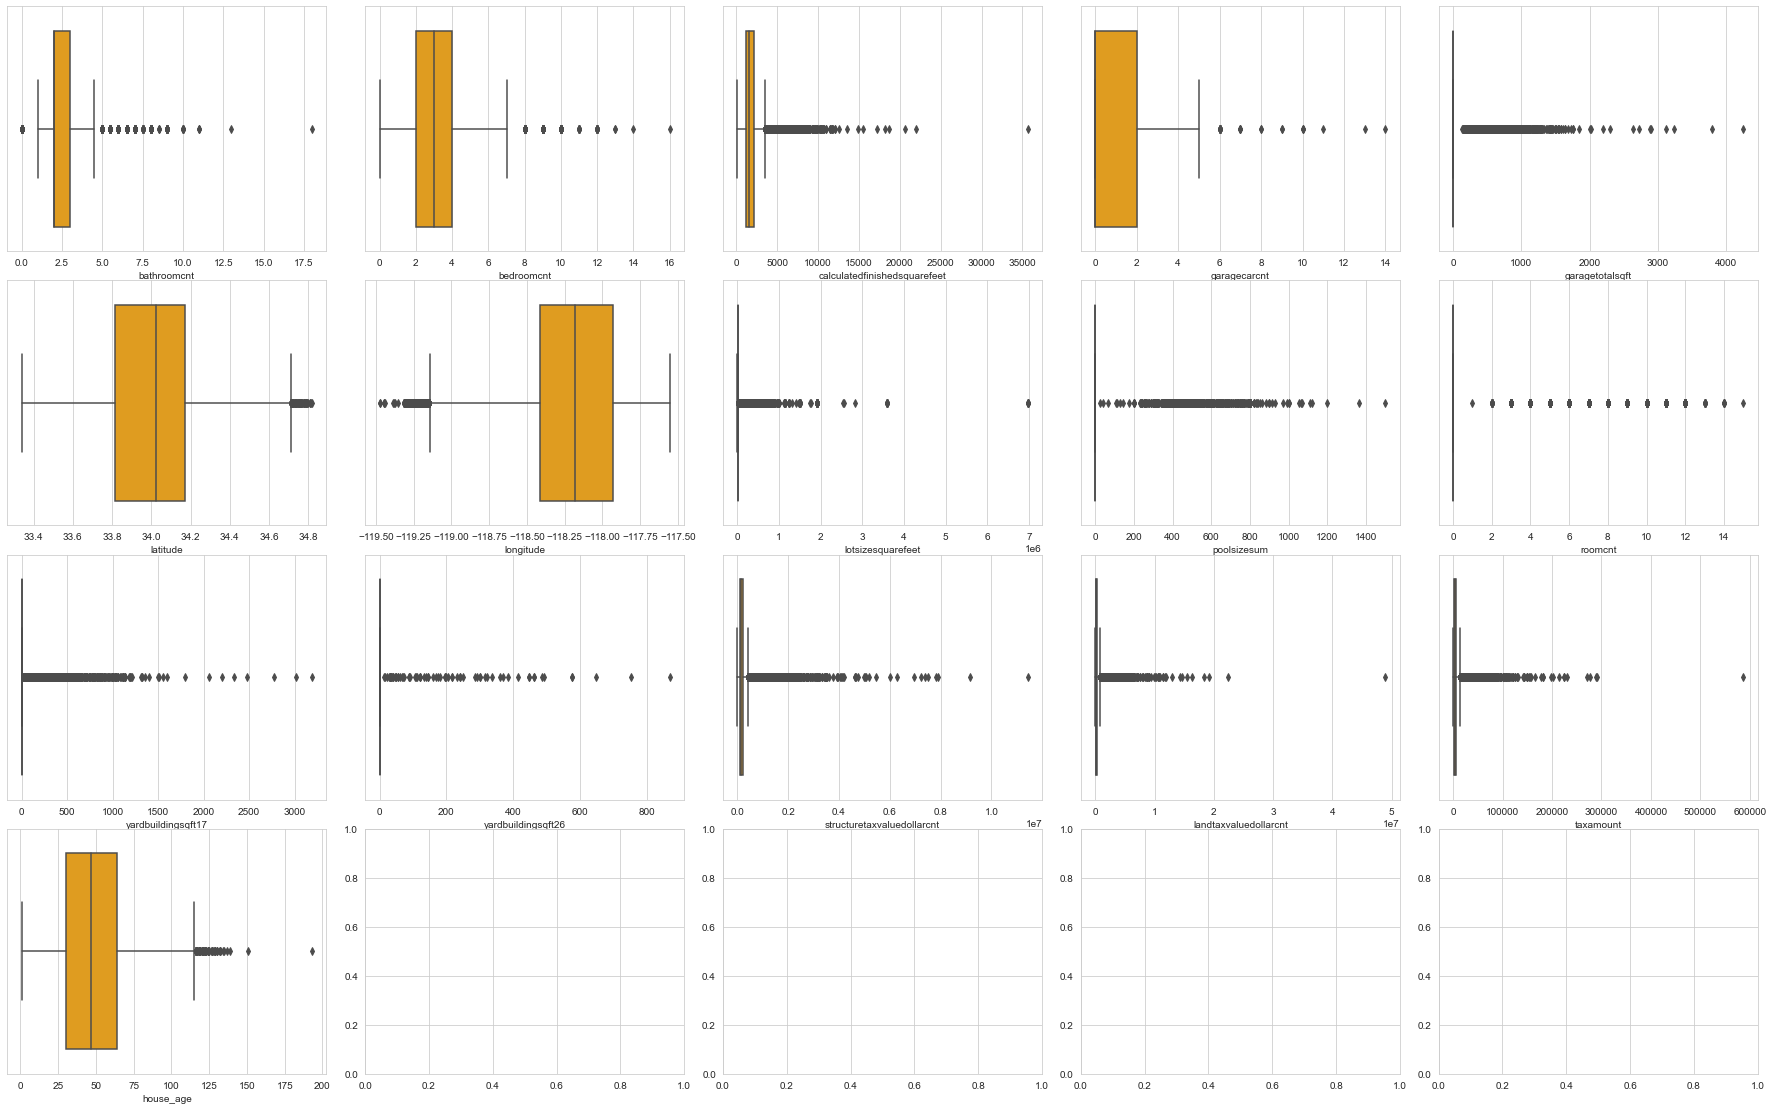

In [102]:
viz.plot_feature_distribution(X2_ohe,num_vars_ohe,subplot_size=(5, 4))

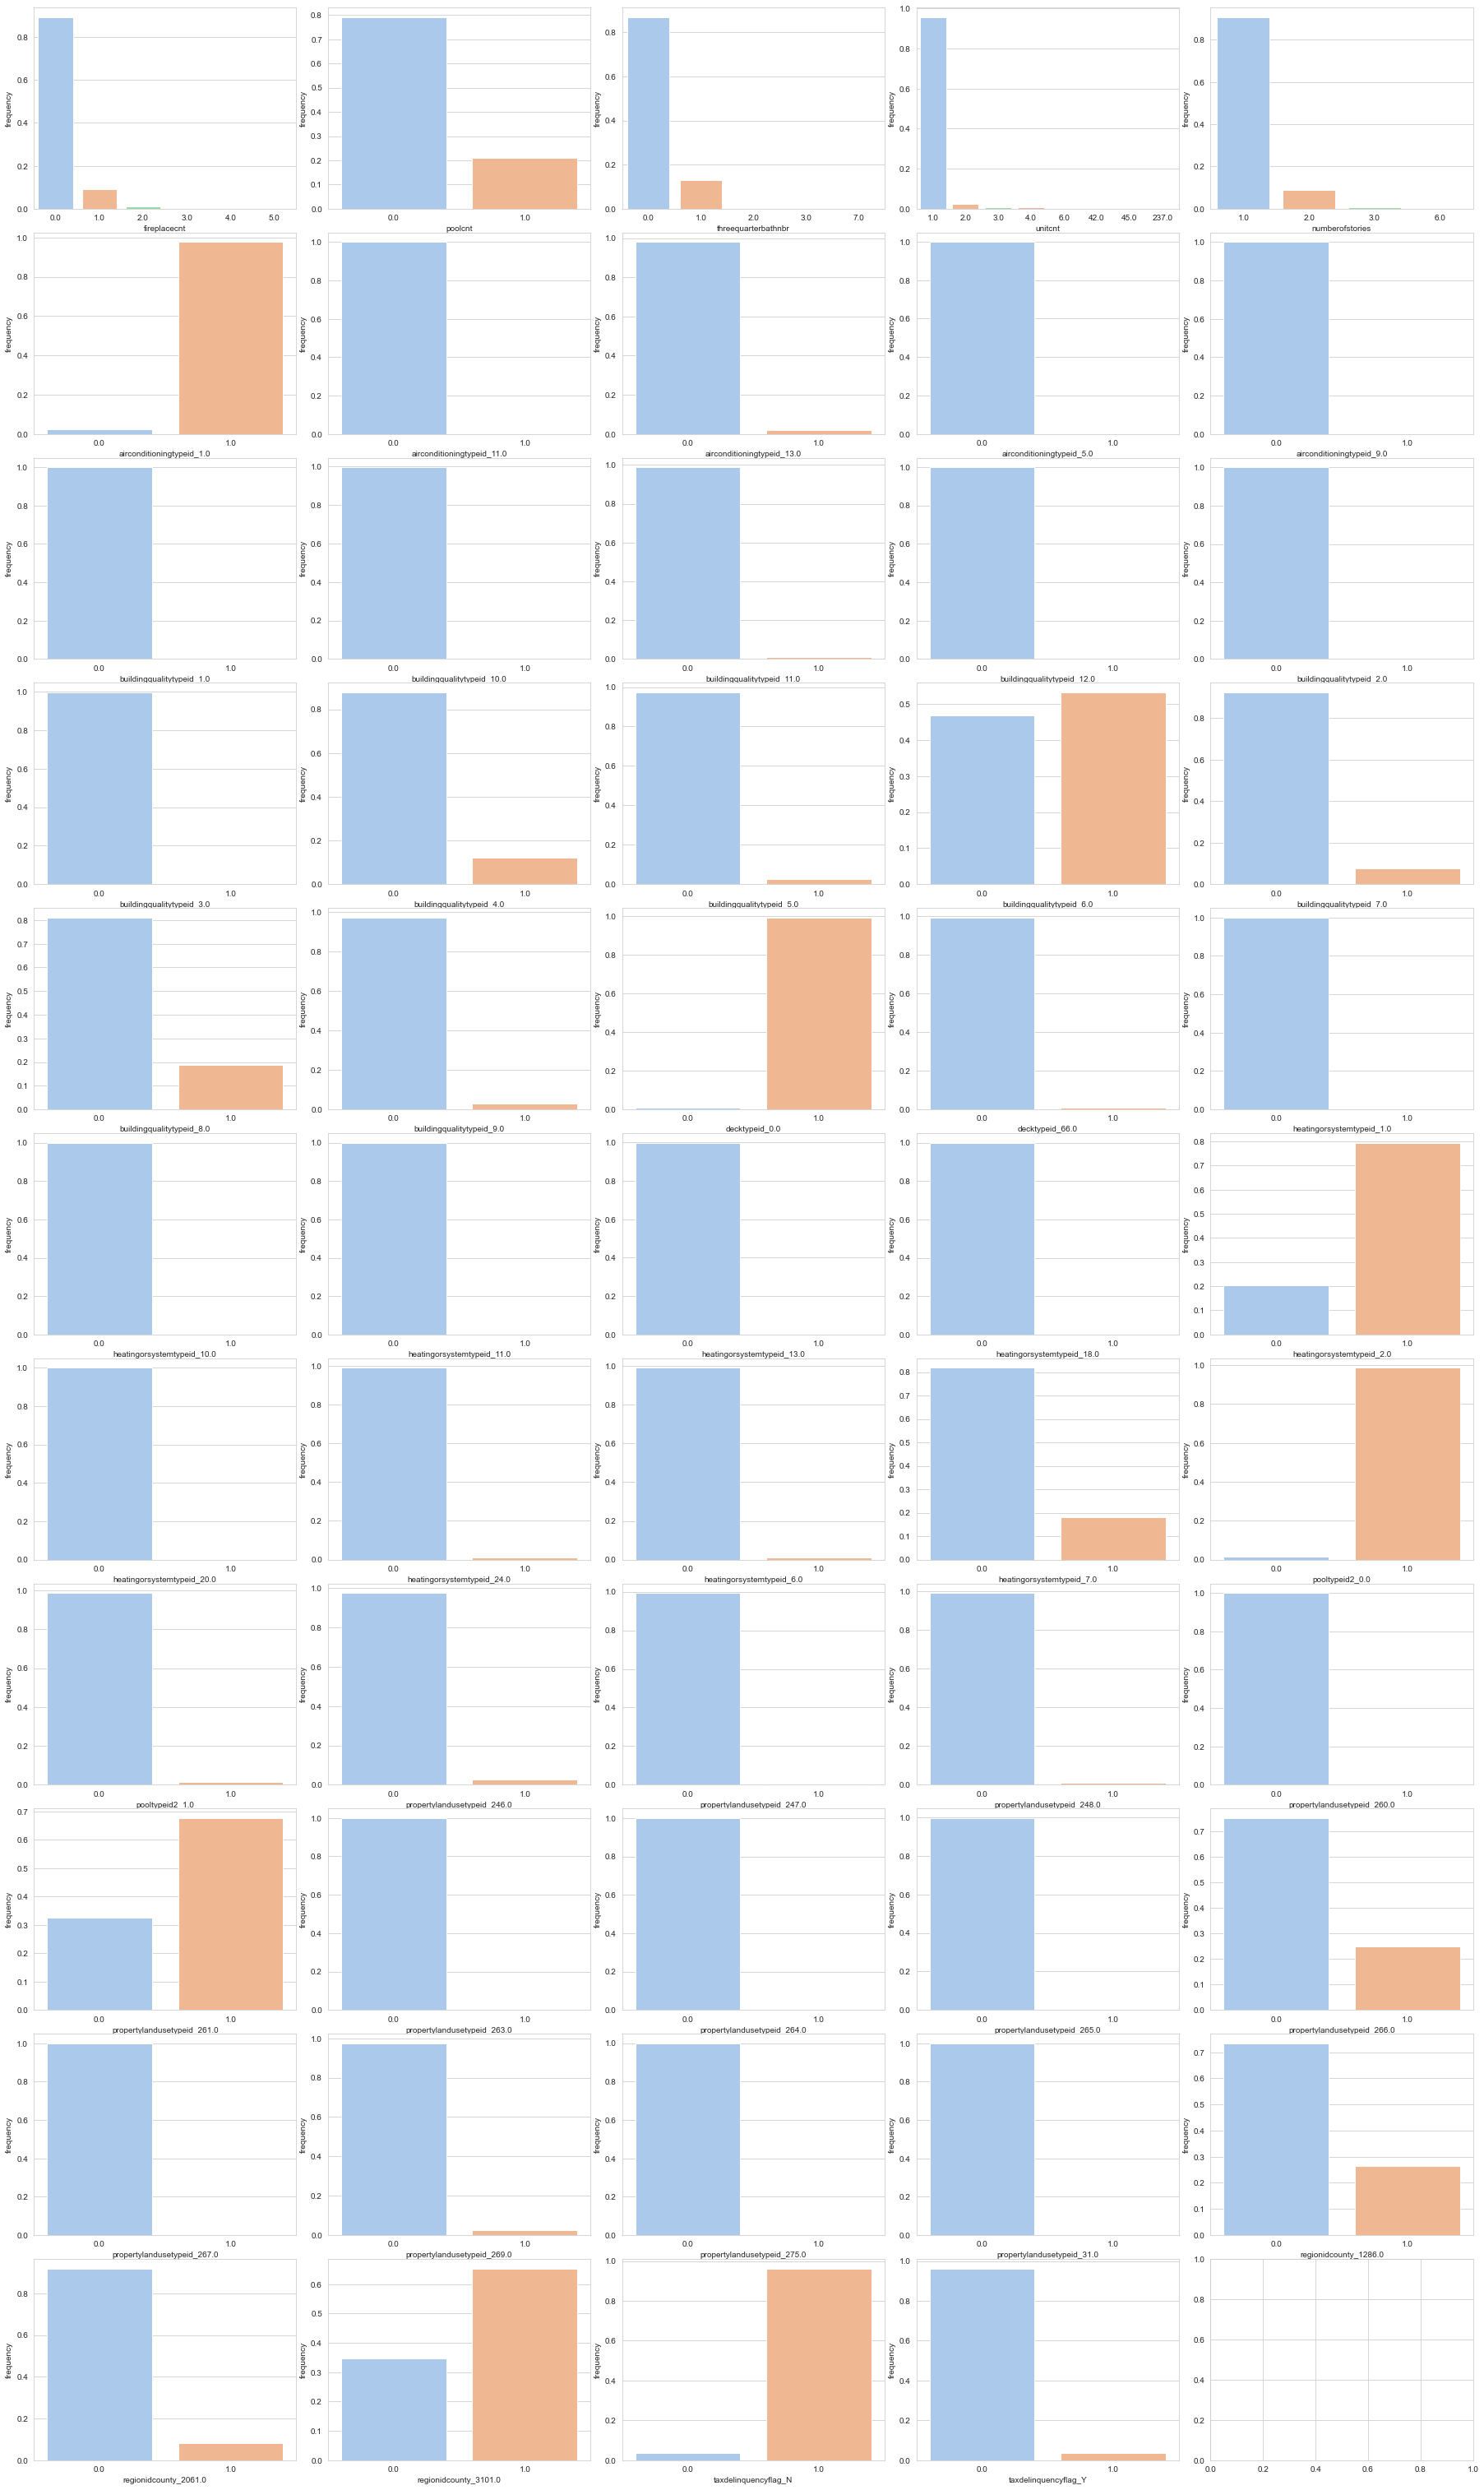

In [103]:
viz.plot_feature_distribution(X2_ohe,cat_vars_ohe,subplot_size=(5, 4),cat = True)

### Correlation

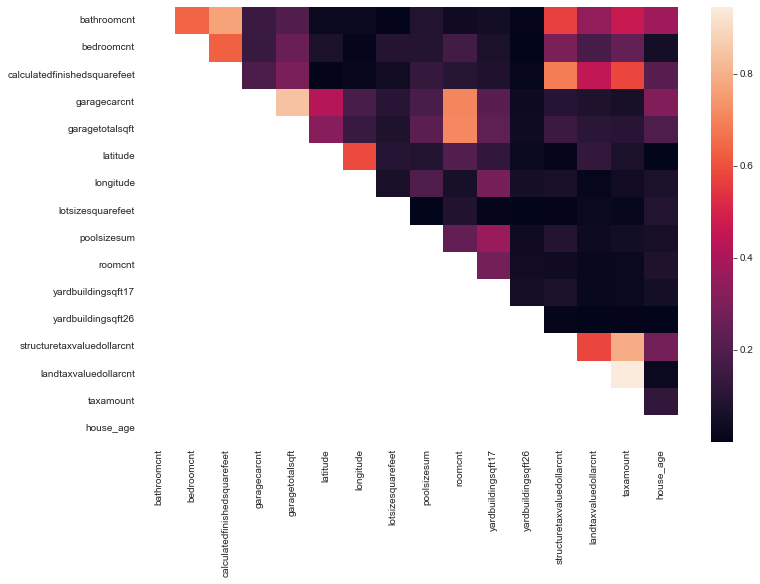

<Figure size 432x288 with 0 Axes>

In [104]:
viz.plot_correlation(X2_ohe,num_vars_ohe)

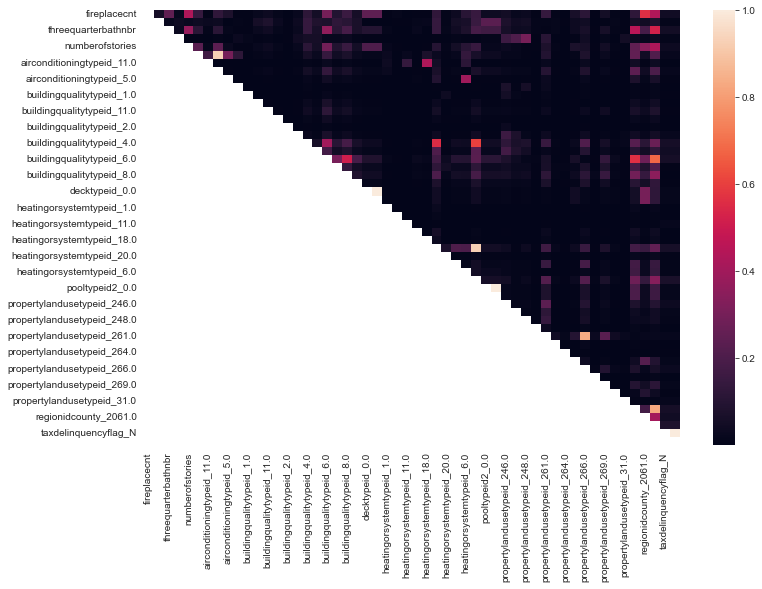

<Figure size 432x288 with 0 Axes>

In [105]:
viz.plot_correlation(X2_ohe,cat_vars_ohe)

#### Features vs Target

In [ ]:
viz.feature_target_scatter_plot(data=X2_split_ohe)

### Save the filled dataset

In [ ]:
X2_split_ohe.to_csv(dir_path="../data/lvl2_ohe")

## Log Scaling

As we can see from the features' distribution, a lot of them show signs of skewness towards large values.
These features are mostly about surface area and money amount.
Let's see if logarithmic scaling can solve the problem.

In [ ]:
to_log_vars = ["calculatedfinishedsquarefeet", "garagetotalsqft", "lotsizesquarefeet", "taxamount", "landtaxvaluedollarcnt", "structuretaxvaluedollarcnt", "yardbuildingsqft26", "yardbuildingsqft17"]

X3_split_ohe_log = fe.apply_log_scale(data=X2_split_ohe, features_to_scale=to_log_vars)

## Visualization
After Log Scaling

In [ ]:
X3_ohe_log = pd.concat([X3_split_ohe_log.x_train, X3_split_ohe_log.x_test])
X3_ohe_log.info(verbose=True)

In [ ]:
num_vars_ohe = [var for var in X3_ohe_log.columns if len(X3_ohe_log[var].unique()) > 10]
cat_vars_ohe = [var for var in X3_ohe_log.columns if var not in num_vars_ohe]

### Distribution of features

In [ ]:
viz.plot_feature_distribution(X3_ohe_log,num_vars_ohe,subplot_size=(5, 4))

In [ ]:
viz.plot_feature_distribution(X3_ohe_log,cat_vars_ohe,subplot_size=(5, 4),cat = True)

### Correlation

In [ ]:
viz.plot_correlation(X3_ohe_log,num_vars_ohe)

In [ ]:
viz.plot_correlation(X3_ohe_log,cat_vars_ohe)

#### Features vs Target

In [ ]:
viz.feature_target_scatter_plot(data=X3_split_ohe_log)

### Save the scaled dataset

In [ ]:
X3_split_ohe_log.to_csv(dir_path="../data/lvl3_ohe_log")

## Recursive Feature Elimination with Cross Validation

We perform Recursive Feature Elimination in a Cross-Validation loop to find the best number of features.

In [ ]:
def rfecv(rfreg, sample):
    selector = RFECV(rfreg,
                     step=1, # features removed at each step
                     cv=5,   # cross validation folds
                     scoring='neg_mean_squared_error', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                     min_features_to_select=1, # selected features
                     n_jobs=-1,
                     verbose=4)
    selector.fit(sample.x_train,sample.y_train)
    return selector

In [ ]:
rfreg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# x_train, x_test, y_train, y_test = train_test_split(X3_split_ohe_log.x_train, X3_split_ohe_log.y_train, test_size=0.25)
# subset = fe.TrainTestSplit(x_train, x_test, y_train, y_test)

In [ ]:
results = rfecv(rfreg, X3_split_ohe_log)

In [ ]:
# selected features
results.n_features_

In [ ]:
# Best selected features
results.support_

In [ ]:
# Features ranking
best_features = X3_split_ohe_log.x_train.columns[results.support_]
ranked = [x for _,x in sorted(zip(np.argsort(results.ranking_),best_features))]
print(f"Best features ranked: {ranked}")

In [ ]:
results.cv_results_["std_test_score"]

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(
    range(1, len(results.cv_results_["mean_test_score"]) + 1),
    results.cv_results_["mean_test_score"],
)
plt.show()

In [ ]:
print("Optimal number of features : %d" % results.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(30,20))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(results.grid_scores_) + 1),
    results.grid_scores_,
)
plt.show()

In [ ]:
to_drop = [var for var in X3_split_ohe_log.x_train.columns if var not in best_features]
X4_split_rfecv = X3_split_ohe_log.drop_features(features_to_drop=to_drop)

## Save the new dataset

In [ ]:
X4_split_rfecv.to_csv(dir_path="../data/lvl4_rfecv")
best = pd.DataFrame({'best_features': best_features})
best.to_csv('../data/lvl4_rfecv/best_feat_properties_2017.csv', index=False)
best.info()

## Visualization
After RFECV

In [ ]:
X4_rfecv = pd.concat([X4_split_rfecv.x_train, X4_split_rfecv.x_test])
X4_rfecv.info(verbose=True)

In [ ]:
num_vars_rfecv = [var for var in X4_rfecv.columns if len(X4_rfecv[var].unique()) > 10]
cat_vars_rfecv = [var for var in X4_rfecv.columns if var not in num_vars_rfecv]

### Distribution of features

In [ ]:
viz.plot_feature_distribution(X4_rfecv,num_vars_rfecv,subplot_size=(5, 4))

In [ ]:
viz.plot_feature_distribution(X4_rfecv,cat_vars_rfecv,subplot_size=(5, 4),cat = True)

### Correlation

In [ ]:
viz.plot_correlation(X4_rfecv,num_vars_rfecv)

In [ ]:
viz.plot_correlation(X4_rfecv,cat_vars_rfecv)

#### Features vs Target

In [ ]:
viz.feature_target_scatter_plot(data=X4_split_rfecv)

In [ ]:
X4_split_rfecv.x_train.info(verbose=True)

Since `taxdelinquencyflag_N` and `taxdelinquencyflag_Y` contain each other's opposite information, we will keep only one of them.

In [ ]:
# X4_split_rfecv = fe.TrainTestSplit.from_csv_directory(dir_path="../data/lvl4_rfecv") # to reload data in case is needed
X4_split_rfecv = X4_split_rfecv.drop_features(features_to_drop=["taxdelinquencyflag_N"])

In [ ]:
X4_split_rfecv.x_train.info(verbose=True)

As we can see from the cross-validation scores, starting from 13 features, the scores don't change drastically.
So to decrease the dimensionality of the dataset, we will drop some features.
- **buildingqualitytypeid_4.0**, **buildingqualitytypeid_5.0**, **buildingqualitytypeid_6.0**, **buildingqualitytypeid_7.0**, **buildingqualitytypeid_8.0**, **propertylandusetypeid_246.0** beacuse they rank the lowest.
- **taxamount** because it's similar to **structuretaxvaluedollarcnt** and **landtaxvaluedollarcnt**

In [ ]:
X4_final = X4_split_rfecv.drop_features(features_to_drop=['taxamount','buildingqualitytypeid_4.0', 'buildingqualitytypeid_5.0', 'buildingqualitytypeid_6.0', 'buildingqualitytypeid_7.0', 'buildingqualitytypeid_8.0', 'propertylandusetypeid_246.0'])

In [ ]:
X4_final.x_train.info(verbose=True)

## Save the new dataset

In [ ]:
X4_final.to_csv(dir_path="../data/lvl4_rfecv")

Now we are ready.